In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# 数据处理

## 财务数据

财务数据处理的难点在于“报表数据所处的时间”、“报表报告的时间”、“报表修改时间”带来的复杂性。两种处理方式比较合理：
1. 预留充足的时间以便在使用报表数据的时间点上，报表数据是可用的（但不一定是最新的）
2. 无论在哪个时间点上使用报表数据，都只用最新的数据(point-in-time)

## 交易数据

### 停牌

- 停牌在某些时候是可以不处理的，比如计算动量的时候，停牌之后的价格和停牌前的价格计算收益率，可以作为动量的一种衡量
- 但在有的时候，停牌不处理可能会有问题。
    - 比如计算beta，市场收益率每个交易日都是有的，但个股停牌的时候没有，此时如果设为0，直接回归会有大的偏差
    - 另外比如计算波动率，如果设为0，也有问题
    - 从收益率的角度看，如果我们关注点是月收益率，也应当去掉，因为停牌的股票无法交易，也无法调仓
- 我们把停牌超过一个月的观测值删去

# Data

In [3]:
START = '2007-01-01'
END = '2022-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']

In [5]:
stk_info

secID    ticker secShortName cnSpell exchangeCD assetClass  \
0        000001.XSHE    000001         平安银行    PAYH       XSHE          E   
1        000002.XSHE    000002          万科A     WKA       XSHE          E   
2        000003.XSHE    000003        PT金田A   PTJTA       XSHE          E   
3        000004.XSHE    000004         国华网安    GHWA       XSHE          E   
4        000005.XSHE    000005         ST星源    STXY       XSHE          E   
5        000006.XSHE    000006         深振业A    SZYA       XSHE          E   
6        000007.XSHE    000007        *ST全新   *STQX       XSHE          E   
7        000008.XSHE    000008         神州高铁    SZGT       XSHE          E   
...              ...       ...          ...     ...        ...        ...   
24126    900950.XSHG    900950         新城B股    XCBG       XSHG          E   
24127    900951.XSHG    900951         退市大化    TSDH       XSHG          E   
24128    900952.XSHG    900952         锦港B股    JGBG       XSHG          E   
24129    900953.XSHG    900953          凯马B     KMB       XSHG          E   
24130    900955.XSHG    900955       *ST海创B  *STHCB       XSHG          E   
24131    900956.XSHG    900956         东贝B股    DBBG       XSHG          E   
24132    900957.XSHG    900957         凌云B股    LYBG       XSHG          E   
28065  DY600018.XSHG  DY600018         上港集箱    SGJX       XSHG          E   

      listStatusCD    listDate transCurrCD          ISIN  partyID  delistDate  
0                L  1991-04-03         CNY  CNE000000040      2.0         NaN  
1                L  1991-01-29         CNY  CNE0000000T2      3.0         NaN  
2               DE  1991-07-03         CNY  CNE1000031Y5      4.0  2002-06-14  
3                L  1991-01-14         CNY  CNE0000000Y2      5.0         NaN  
4                L  1990-12-10         CNY  CNE0000001L7      6.0         NaN  
5                L  1992-04-27         CNY  CNE000000164      7.0         NaN  
6                L  1992-04-13         CNY  CNE0000000P0      8.0         NaN  
7                L  1992-05-07         CNY  CNE0000001C6      9.0         NaN  
...            ...         ...         ...           ...      ...         ...  
24126           DE  1997-10-16         USD  CNE000000TH1   1429.0  2015-11-23  
24127           DE  1997-10-21         USD  CNE000000TJ7   1430.0  2020-08-27  
24128            L  1998-05-19         USD  CNE000000W88    763.0         NaN  
24129            L  1998-06-24         USD  CNE000000WP8   1431.0         NaN  
24130            L  1999-01-18         USD  CNE000000YC2   1063.0         NaN  
24131           DE  1999-07-15         USD  CNE000000ZS5   1432.0  2020-11-23  
24132            L  2000-07-28         USD  CNE0000013W9   1433.0         NaN  
28065           DE  2000-07-19         CNY           NaN    618.0  2006-10-20  

[4923 rows x 12 columns]

## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [7]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513065 entries, 0 to 513064
Data columns (total 3 columns):
secID        513065 non-null object
tradeDate    513065 non-null object
STflg        513065 non-null object
dtypes: object(3)
memory usage: 11.7+ MB


In [8]:
st_df

secID   tradeDate STflg
0       000001.XSHE  2007-01-04     S
1       000001.XSHE  2007-01-05     S
2       000001.XSHE  2007-01-08     S
3       000001.XSHE  2007-01-09     S
4       000001.XSHE  2007-01-10     S
5       000001.XSHE  2007-01-11     S
6       000001.XSHE  2007-01-12     S
7       000001.XSHE  2007-01-15     S
...             ...         ...   ...
513057  900955.XSHG  2022-03-04   *ST
513058  900955.XSHG  2022-03-07   *ST
513059  900955.XSHG  2022-03-08   *ST
513060  900955.XSHG  2022-03-09   *ST
513061  900955.XSHG  2022-03-10   *ST
513062  900955.XSHG  2022-03-11   *ST
513063  900955.XSHG  2022-03-14   *ST
513064  900955.XSHG  2022-03-15   *ST

[513065 rows x 3 columns]

In [9]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Book value

Book/Market ratio, 简称BM，也即价值因子，反映了公司的账面价值和市值的比值。Fama French (1993) 发现估值低(BM高)的股票和高的相比，预期收益为正。

BM ratio Fama-French(1993) 原文的构造方法：
- 每年的12月底的 book equity
- 每年12月最后一个交易日的mktcap
- 上述二者相除，得到 BM ratio
- 这个 BM ratio 作为下一年6月至下下一年5月的 portfolio 的 sorting variable

处理思路：
- 优矿的数据有发布日期，数据日期
- 这里book value比较简单，只取年报数据，也就是“数据日期”都是12月
- 取发布日期最晚，也就是最新的（也许年报和1季报中数据不同，或者年报发布后马上有更改），但不晚于次年6月

In [10]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,reportType="A",beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df.pkl')

In [11]:
fundmen_df = pd.read_pickle('./data/fundmen_df.pkl')

In [12]:
fundmen_df

secID publishDate     endDate  endDateRep           actPubtime  \
0       000001.XSHE  2021-10-21  2020-12-31  2021-09-30  2021-10-20 17:39:15   
1       000001.XSHE  2021-08-20  2020-12-31  2021-06-30  2021-08-19 17:20:35   
2       000001.XSHE  2021-04-21  2020-12-31  2021-03-31  2021-04-20 17:54:36   
3       000001.XSHE  2021-02-02  2020-12-31  2020-12-31  2021-02-01 18:58:35   
4       000001.XSHE  2021-02-02  2019-12-31  2020-12-31  2021-02-01 18:58:35   
5       000001.XSHE  2020-10-22  2019-12-31  2020-09-30  2020-10-21 19:21:43   
6       000001.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 17:50:41   
7       000001.XSHE  2020-04-21  2019-12-31  2020-03-31  2020-04-20 18:42:38   
...             ...         ...         ...         ...                  ...   
246098  900957.XSHG  2009-08-01  2008-12-31  2009-06-30  2009-07-31 18:00:00   
246099  900957.XSHG  2009-04-18  2008-12-31  2009-03-31  2009-04-17 18:00:00   
246100  900957.XSHG  2009-03-26  2008-12-31  2008-12-31  2009-03-25 18:00:00   
246101  900957.XSHG  2009-03-26  2007-12-31  2008-12-31  2009-03-25 18:00:00   
246102  900957.XSHG  2008-10-24  2007-12-31  2008-09-30  2008-10-23 18:00:00   
246103  900957.XSHG  2008-08-25  2007-12-31  2008-06-30  2008-08-24 18:00:00   
246104  900957.XSHG  2008-04-24  2007-12-31  2008-03-31  2008-04-23 18:00:00   
246105  900957.XSHG  2008-04-08  2007-12-31  2007-12-31  2008-04-07 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                12  3.641310e+11  3.641310e+11          NaN  
1                12  3.641310e+11  3.641310e+11          NaN  
2                12  3.641310e+11  3.641310e+11          NaN  
3                12  3.641310e+11  3.641310e+11          NaN  
4                12  3.129830e+11  3.129830e+11          NaN  
5                12  3.129830e+11  3.129830e+11          NaN  
6                12  3.129830e+11  3.129830e+11          NaN  
7                12  3.129830e+11  3.129830e+11          NaN  
...             ...           ...           ...          ...  
246098           12  4.902596e+08  4.369354e+08  53324231.94  
246099           12  4.902596e+08  4.369354e+08  53324231.94  
246100           12  4.902596e+08  4.369354e+08  53324231.94  
246101           12  4.363166e+08  3.769447e+08  59371874.07  
246102           12  4.363166e+08  3.769447e+08  59371874.07  
246103           12  4.363166e+08  3.769447e+08  59371874.07  
246104           12  4.363166e+08  3.769447e+08  59371874.07  
246105           12  4.363166e+08  3.769447e+08  59371874.07  

[246106 rows x 9 columns]

In [13]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
135178  300720.XSHE  2021-04-27  2019-12-31  2020-12-31  2021-04-26 18:40:28   
135179  300720.XSHE  2020-10-30  2019-12-31  2020-09-30  2020-10-29 19:58:45   
135180  300720.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 22:42:40   
135181  300720.XSHE  2020-04-24  2019-12-31  2020-03-31  2020-04-23 21:04:35   
135182  300720.XSHE  2020-04-24  2019-12-31  2019-12-31  2020-04-23 21:04:35   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
135178           12  4.783596e+08  4.783596e+08          NaN  
135179           12  4.783596e+08  4.783596e+08          NaN  
135180           12  4.783596e+08  4.783596e+08          NaN  
135181           12  4.783596e+08  4.783596e+08          NaN  
135182           12  4.783596e+08  4.783596e+08          NaN

In [14]:
fundmen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246106 entries, 0 to 246105
Data columns (total 9 columns):
secID           246106 non-null object
publishDate     246106 non-null object
endDate         246106 non-null object
endDateRep      246106 non-null object
actPubtime      246106 non-null object
fiscalPeriod    246106 non-null object
TShEquity       244730 non-null float64
TEquityAttrP    244724 non-null float64
minorityInt     187385 non-null float64
dtypes: float64(3), object(6)
memory usage: 16.9+ MB


In [15]:
fundmen_df['fiscalPeriod'].unique()

array(['12'], dtype=object)

In [16]:
fundmen_df[(fundmen_df['secID']=='000001.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
4  000001.XSHE  2021-02-02  2019-12-31  2020-12-31  2021-02-01 18:58:35   
5  000001.XSHE  2020-10-22  2019-12-31  2020-09-30  2020-10-21 19:21:43   
6  000001.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 17:50:41   
7  000001.XSHE  2020-04-21  2019-12-31  2020-03-31  2020-04-20 18:42:38   
8  000001.XSHE  2020-02-14  2019-12-31  2019-12-31  2020-02-13 19:02:36   

  fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
4           12  3.129830e+11  3.129830e+11          NaN  
5           12  3.129830e+11  3.129830e+11          NaN  
6           12  3.129830e+11  3.129830e+11          NaN  
7           12  3.129830e+11  3.129830e+11          NaN  
8           12  3.129830e+11  3.129830e+11          NaN

In [17]:
fundmen_df[(fundmen_df['secID'] == '300720.XSHE') & (fundmen_df['endDate']=='2018-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
135183  300720.XSHE  2020-04-24  2018-12-31  2019-12-31  2020-04-23 21:04:35   
135184  300720.XSHE  2019-10-30  2018-12-31  2019-09-30  2019-10-29 19:22:34   
135185  300720.XSHE  2019-08-28  2018-12-31  2019-06-30  2019-08-27 19:42:06   
135186  300720.XSHE  2019-04-26  2018-12-31  2019-03-31  2019-04-25 23:27:06   
135187  300720.XSHE  2019-04-26  2018-12-31  2018-12-31  2019-04-25 23:27:06   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
135183           12  4.555515e+08  4.555515e+08          NaN  
135184           12  4.555515e+08  4.555515e+08          NaN  
135185           12  4.555515e+08  4.555515e+08          NaN  
135186           12  4.555515e+08  4.555515e+08          NaN  
135187           12  4.555515e+08  4.555515e+08          NaN

- `publishDate`: 实际公告日期
- `endDate`：数值所在日期
- `endDateRep`：数值所在报表日期。03-31是一季报，06-30是半年报，09-30是三季报，12-31是年报。后面的报表可能会对初始值做修改。

在t年6月分组时，应当取最新更新过的t-1年12月31日的Book数值。

In [18]:
fundmen_df.drop(['actPubtime','fiscalPeriod', 'endDateRep'],axis=1, inplace=True)

In [19]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [20]:
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year

In [21]:
fundmen_df

secID publishDate    endDate     TShEquity  TEquityAttrP  \
0       000001.XSHE  2021-10-21 2020-12-31  3.641310e+11  3.641310e+11   
1       000001.XSHE  2021-08-20 2020-12-31  3.641310e+11  3.641310e+11   
2       000001.XSHE  2021-04-21 2020-12-31  3.641310e+11  3.641310e+11   
3       000001.XSHE  2021-02-02 2020-12-31  3.641310e+11  3.641310e+11   
4       000001.XSHE  2021-02-02 2019-12-31  3.129830e+11  3.129830e+11   
5       000001.XSHE  2020-10-22 2019-12-31  3.129830e+11  3.129830e+11   
6       000001.XSHE  2020-08-28 2019-12-31  3.129830e+11  3.129830e+11   
7       000001.XSHE  2020-04-21 2019-12-31  3.129830e+11  3.129830e+11   
...             ...         ...        ...           ...           ...   
246098  900957.XSHG  2009-08-01 2008-12-31  4.902596e+08  4.369354e+08   
246099  900957.XSHG  2009-04-18 2008-12-31  4.902596e+08  4.369354e+08   
246100  900957.XSHG  2009-03-26 2008-12-31  4.902596e+08  4.369354e+08   
246101  900957.XSHG  2009-03-26 2007-12-31  4.363166e+08  3.769447e+08   
246102  900957.XSHG  2008-10-24 2007-12-31  4.363166e+08  3.769447e+08   
246103  900957.XSHG  2008-08-25 2007-12-31  4.363166e+08  3.769447e+08   
246104  900957.XSHG  2008-04-24 2007-12-31  4.363166e+08  3.769447e+08   
246105  900957.XSHG  2008-04-08 2007-12-31  4.363166e+08  3.769447e+08   

        minorityInt  pub_month  pub_year  data_year  
0               NaN         10      2021       2020  
1               NaN          8      2021       2020  
2               NaN          4      2021       2020  
3               NaN          2      2021       2020  
4               NaN          2      2021       2019  
5               NaN         10      2020       2019  
6               NaN          8      2020       2019  
7               NaN          4      2020       2019  
...             ...        ...       ...        ...  
246098  53324231.94          8      2009       2008  
246099  53324231.94          4      2009       2008  
246100  53324231.94          3      2009       2008  
246101  59371874.07          3      2009       2007  
246102  59371874.07         10      2008       2007  
246103  59371874.07          8      2008       2007  
246104  59371874.07          4      2008       2007  
246105  59371874.07          4      2008       2007  

[246106 rows x 9 columns]

In [22]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate     TShEquity  TEquityAttrP  \
135178  300720.XSHE  2021-04-27 2019-12-31  4.783596e+08  4.783596e+08   
135179  300720.XSHE  2020-10-30 2019-12-31  4.783596e+08  4.783596e+08   
135180  300720.XSHE  2020-08-28 2019-12-31  4.783596e+08  4.783596e+08   
135181  300720.XSHE  2020-04-24 2019-12-31  4.783596e+08  4.783596e+08   
135182  300720.XSHE  2020-04-24 2019-12-31  4.783596e+08  4.783596e+08   

        minorityInt  pub_month  pub_year  data_year  
135178          NaN          4      2021       2019  
135179          NaN         10      2020       2019  
135180          NaN          8      2020       2019  
135181          NaN          4      2020       2019  
135182          NaN          4      2020       2019

In [23]:
fundmen_df['pub_year'] - fundmen_df['data_year'] 

0         1
1         1
2         1
3         1
4         2
5         1
6         1
7         1
         ..
246098    1
246099    1
246100    1
246101    2
246102    1
246103    1
246104    1
246105    1
Length: 246106, dtype: int64

In [24]:
# 每年6月底计算时，只能看到publishDate在6月之前的数值。
# 取 endDate 相同时，publishDate 最晚（但小于等于6）的那个数值
# 同时pub_year - data_year 不能大于1
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year
fundmen_df = fundmen_df[fundmen_df['pub_year'] - fundmen_df['data_year'] == 1]
fundmen_df = fundmen_df[fundmen_df['pub_month'] <= 6]
fundmen_df.sort_values(['secID','endDate','publishDate'],inplace=True)

In [25]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate     TShEquity  TEquityAttrP  \
135181  300720.XSHE  2020-04-24 2019-12-31  4.783596e+08  4.783596e+08   
135182  300720.XSHE  2020-04-24 2019-12-31  4.783596e+08  4.783596e+08   

        minorityInt  pub_month  pub_year  data_year  
135181          NaN          4      2020       2019  
135182          NaN          4      2020       2019

In [26]:
fundmen_df = fundmen_df.groupby(['secID','endDate'],as_index=False).first()

In [27]:
fundmen_df['bm_date'] = fundmen_df['endDate'].dt.to_period('M')

In [28]:
fundmen_df

secID    endDate publishDate     TShEquity  TEquityAttrP  \
0      000001.XSHE 2007-12-31  2008-03-20  1.300606e+10  1.300606e+10   
1      000001.XSHE 2008-12-31  2009-03-20  1.640079e+10  1.640079e+10   
2      000001.XSHE 2009-12-31  2010-03-12  2.046961e+10  2.046961e+10   
3      000001.XSHE 2010-12-31  2011-02-25  3.351288e+10  3.351288e+10   
4      000001.XSHE 2011-12-31  2012-03-09  7.538058e+10  7.331084e+10   
5      000001.XSHE 2012-12-31  2013-03-08  8.479878e+10  8.479878e+10   
6      000001.XSHE 2013-12-31  2014-03-07  1.120810e+11  1.120810e+11   
7      000001.XSHE 2014-12-31  2015-03-13  1.309490e+11  1.309490e+11   
...            ...        ...         ...           ...           ...   
42725  900957.XSHG 2013-12-31  2014-03-19  3.890554e+08  3.877593e+08   
42726  900957.XSHG 2014-12-31  2015-04-10  4.072107e+08  3.940309e+08   
42727  900957.XSHG 2015-12-31  2016-03-30  4.106786e+08  3.973929e+08   
42728  900957.XSHG 2016-12-31  2017-03-25  3.938268e+08  3.930721e+08   
42729  900957.XSHG 2017-12-31  2018-04-10  4.238426e+08  4.231040e+08   
42730  900957.XSHG 2018-12-31  2019-03-30  4.515278e+08  4.508051e+08   
42731  900957.XSHG 2019-12-31  2020-04-25  4.768689e+08  4.761021e+08   
42732  900957.XSHG 2020-12-31  2021-04-09  4.987276e+08  4.979110e+08   

        minorityInt  pub_month  pub_year  data_year  bm_date  
0               NaN          3      2008       2007  2007-12  
1               NaN          3      2009       2008  2008-12  
2               NaN          3      2010       2009  2009-12  
3               NaN          2      2011       2010  2010-12  
4      2.069747e+09          3      2012       2011  2011-12  
5               NaN          3      2013       2012  2012-12  
6               NaN          3      2014       2013  2013-12  
7               NaN          3      2015       2014  2014-12  
...             ...        ...       ...        ...      ...  
42725  1.296075e+06          3      2014       2013  2013-12  
42726  1.317981e+07          4      2015       2014  2014-12  
42727  1.328570e+07          3      2016       2015  2015-12  
42728  7.546643e+05          3      2017       2016  2016-12  
42729  7.386715e+05          4      2018       2017  2017-12  
42730  7.226781e+05          3      2019       2018  2018-12  
42731  7.667705e+05          4      2020       2019  2019-12  
42732  8.165551e+05          4      2021       2020  2020-12  

[42733 rows x 10 columns]

In [29]:
fundmen_df.fillna(0,inplace=True)

In [30]:
fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']

In [31]:
fundmen_df = fundmen_df[fundmen_df['book'] > 0]

In [32]:
fundmen_df

secID    endDate publishDate     TShEquity  TEquityAttrP  \
0      000001.XSHE 2007-12-31  2008-03-20  1.300606e+10  1.300606e+10   
1      000001.XSHE 2008-12-31  2009-03-20  1.640079e+10  1.640079e+10   
2      000001.XSHE 2009-12-31  2010-03-12  2.046961e+10  2.046961e+10   
3      000001.XSHE 2010-12-31  2011-02-25  3.351288e+10  3.351288e+10   
4      000001.XSHE 2011-12-31  2012-03-09  7.538058e+10  7.331084e+10   
5      000001.XSHE 2012-12-31  2013-03-08  8.479878e+10  8.479878e+10   
6      000001.XSHE 2013-12-31  2014-03-07  1.120810e+11  1.120810e+11   
7      000001.XSHE 2014-12-31  2015-03-13  1.309490e+11  1.309490e+11   
...            ...        ...         ...           ...           ...   
42725  900957.XSHG 2013-12-31  2014-03-19  3.890554e+08  3.877593e+08   
42726  900957.XSHG 2014-12-31  2015-04-10  4.072107e+08  3.940309e+08   
42727  900957.XSHG 2015-12-31  2016-03-30  4.106786e+08  3.973929e+08   
42728  900957.XSHG 2016-12-31  2017-03-25  3.938268e+08  3.930721e+08   
42729  900957.XSHG 2017-12-31  2018-04-10  4.238426e+08  4.231040e+08   
42730  900957.XSHG 2018-12-31  2019-03-30  4.515278e+08  4.508051e+08   
42731  900957.XSHG 2019-12-31  2020-04-25  4.768689e+08  4.761021e+08   
42732  900957.XSHG 2020-12-31  2021-04-09  4.987276e+08  4.979110e+08   

        minorityInt  pub_month  pub_year  data_year  bm_date          book  
0      0.000000e+00          3      2008       2007  2007-12  1.300606e+10  
1      0.000000e+00          3      2009       2008  2008-12  1.640079e+10  
2      0.000000e+00          3      2010       2009  2009-12  2.046961e+10  
3      0.000000e+00          2      2011       2010  2010-12  3.351288e+10  
4      2.069747e+09          3      2012       2011  2011-12  7.331084e+10  
5      0.000000e+00          3      2013       2012  2012-12  8.479878e+10  
6      0.000000e+00          3      2014       2013  2013-12  1.120810e+11  
7      0.000000e+00          3      2015       2014  2014-12  1.309490e+11  
...             ...        ...       ...        ...      ...           ...  
42725  1.296075e+06          3      2014       2013  2013-12  3.877593e+08  
42726  1.317981e+07          4      2015       2014  2014-12  3.940309e+08  
42727  1.328570e+07          3      2016       2015  2015-12  3.973929e+08  
42728  7.546643e+05          3      2017       2016  2016-12  3.930721e+08  
42729  7.386715e+05          4      2018       2017  2017-12  4.231040e+08  
42730  7.226781e+05          3      2019       2018  2018-12  4.508051e+08  
42731  7.667705e+05          4      2020       2019  2019-12  4.761021e+08  
42732  8.165551e+05          4      2021       2020  2020-12  4.979110e+08  

[41820 rows x 11 columns]

In [33]:
np.allclose(fundmen_df['book'],fundmen_df['TEquityAttrP'])

False

In [34]:
fundmen_df[fundmen_df['book']-fundmen_df['TEquityAttrP'] > 10]

secID    endDate publishDate     TShEquity  TEquityAttrP  \
756    000063.XSHE 2016-12-31  2017-03-24  4.088509e+10  2.640115e+10   
757    000063.XSHE 2017-12-31  2018-03-16  4.538015e+10  3.164688e+10   
758    000063.XSHE 2018-12-31  2019-03-28  3.296068e+10  2.289758e+10   
759    000063.XSHE 2019-12-31  2020-03-28  3.795430e+10  2.882687e+10   
16070  002807.XSHE 2016-12-31  2017-03-15  9.012908e+09  8.751954e+09   
26208  600145.XSHG 2018-12-31  2019-05-09  6.331054e+08  6.331054e+08   
40583  603950.XSHG 2019-12-31  2020-04-14  1.113810e+09  1.090588e+09   
41195  688122.XSHG 2010-12-31  2011-02-28  4.866031e+08  4.866031e+08   

        minorityInt  pub_month  pub_year  data_year  bm_date          book  
756    5.162612e+09          3      2017       2016  2016-12  3.572248e+10  
757    4.411945e+09          3      2018       2017  2017-12  4.096820e+10  
758    3.810735e+09          3      2019       2018  2018-12  2.914994e+10  
759    2.875066e+09          3      2020       2019  2019-12  3.507923e+10  
16070  2.609530e+08          3      2017       2016  2016-12  8.751955e+09  
26208 -2.490678e+06          5      2019       2018  2018-12  6.355961e+08  
40583  2.322100e+07          4      2020       2019  2019-12  1.090589e+09  
41195 -1.193497e+04          2      2011       2010  2010-12  4.866150e+08

## Risk free rate

In [35]:
rf = pd.read_csv("rf-monthly.csv").drop(["Unnamed: 4", "年份_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [36]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
..       ...       ...
389  2021-07  0.002015
390  2021-08  0.001969
391  2021-09  0.001980
392  2021-10  0.002027
393  2021-11  0.002055
394  2021-12  0.002079
395  2022-01  0.002083
396  2022-02  0.002083

[397 rows x 2 columns]

## Beta

In [37]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

beta_df

beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

In [38]:
# # Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(lower_q),upper=beta_df['Beta60'].quantile(up_q))
# beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(lower_q),upper=beta_df['Beta120'].quantile(up_q))

### Monthly beta

In [39]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

beta_m_df.rename(columns={'Beta252':'beta'},inplace=True)

beta_m_df

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
501234  689009.XSHG  2021-08  1.0727
501235  689009.XSHG  2021-09  1.0100
501236  689009.XSHG  2021-10  0.8570
501237  689009.XSHG  2021-11  0.7546
501238  689009.XSHG  2021-12  0.5898
501239  689009.XSHG  2022-01  0.5326
501240  689009.XSHG  2022-02  0.5294
501241  689009.XSHG  2022-03  0.5710

[501242 rows x 3 columns]

## Trading data

In [40]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   "closePrice",
#                                                   "negMarketValue"],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [41]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)

### Exclude ST

In [42]:
stk_df.dropna().shape

(9934190, 8)

In [43]:
stk_df.shape

(9934190, 8)

In [44]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [45]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [46]:
stk_df.drop('STflg',axis=1,inplace=True)

In [47]:
stk_df.shape

(9535739, 8)

### Monthly trading df

In [48]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()

#### Fill na months

In [49]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [50]:
full_dates = np.sort(stk_df['ym'].unique())

In [51]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 34.6 s, sys: 200 ms, total: 34.8 s
Wall time: 34.8 s


In [52]:
stk_df_m.reset_index(drop=True, inplace=True)

In [53]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
507459  900957.XSHG  2021-08 2021-08-31          0.626       0.612   
507460  900957.XSHG  2021-09 2021-09-30          0.655       0.667   
507461  900957.XSHG  2021-10 2021-10-29          0.636       0.640   
507462  900957.XSHG  2021-11 2021-11-30          0.623       0.614   
507463  900957.XSHG  2021-12 2021-12-31          0.635       0.636   
507464  900957.XSHG  2022-01 2022-01-28          0.617       0.622   
507465  900957.XSHG  2022-02 2022-02-28          0.616       0.615   
507466  900957.XSHG  2022-03 2022-03-14          0.606       0.594   

        negMarketValue  turnoverValue  turnoverRate  
0         4.266117e+10   1.410758e+09        0.0316  
1         5.616330e+10   1.479466e+09        0.0270  
2         5.890714e+10   6.552881e+08        0.0112  
3         6.197651e+10   1.408136e+09        0.0228  
4         7.448652e+10   1.440425e+09        0.0200  
5         5.593078e+10   5.452159e+08        0.0096  
6         6.574629e+10   1.019671e+09        0.0154  
7         5.850212e+10   5.328429e+08        0.0089  
...                ...            ...           ...  
507459    1.116880e+08   3.033640e+05        0.0027  
507460    1.218080e+08   2.086830e+05        0.0017  
507461    1.168400e+08   6.162200e+04        0.0005  
507462    1.120560e+08   1.161060e+05        0.0010  
507463    1.161040e+08   1.059960e+05        0.0009  
507464    1.135280e+08   1.319240e+05        0.0012  
507465    1.122400e+08   9.851400e+04        0.0009  
507466    1.083760e+08   1.005700e+05        0.0009  

[507467 rows x 8 columns]

In [54]:
stk_df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507467 entries, 0 to 507466
Data columns (total 8 columns):
secID             507467 non-null object
ym                507467 non-null period[M]
tradeDate         484453 non-null datetime64[ns]
preClosePrice     484453 non-null float64
closePrice        484453 non-null float64
negMarketValue    484453 non-null float64
turnoverValue     484453 non-null float64
turnoverRate      484453 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1), period[M](1)
memory usage: 31.0+ MB


In [55]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [56]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

# # Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_date'] = stk_df_m.groupby('secID')['ym'].shift()

stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

stk_df_m

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
0       000001.XSHE  2007-06        953.780   1.410758e+09        0.0316   
1       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
2       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
3       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
4       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
5       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
6       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
7       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
...             ...      ...            ...            ...           ...   
507459  900957.XSHG  2021-08          0.626   3.033640e+05        0.0027   
507460  900957.XSHG  2021-09          0.655   2.086830e+05        0.0017   
507461  900957.XSHG  2021-10          0.636   6.162200e+04        0.0005   
507462  900957.XSHG  2021-11          0.623   1.161060e+05        0.0010   
507463  900957.XSHG  2021-12          0.635   1.059960e+05        0.0009   
507464  900957.XSHG  2022-01          0.617   1.319240e+05        0.0012   
507465  900957.XSHG  2022-02          0.616   9.851400e+04        0.0009   
507466  900957.XSHG  2022-03          0.606   1.005700e+05        0.0009   

             ret       mkt_cap mkt_cap_date  
0            NaN           NaN          NaT  
1       0.316497  4.266117e+10      2007-06  
2       0.048855  5.616330e+10      2007-07  
3       0.052105  5.890714e+10      2007-08  
4       0.201851  6.197651e+10      2007-09  
5      -0.249116  7.448652e+10      2007-10  
6       0.069845  5.593078e+10      2007-11  
7      -0.137306  6.574629e+10      2007-12  
...          ...           ...          ...  
507459 -0.058462  1.186800e+08      2021-07  
507460  0.089869  1.116880e+08      2021-08  
507461 -0.040480  1.218080e+08      2021-09  
507462 -0.040625  1.168400e+08      2021-10  
507463  0.035831  1.120560e+08      2021-11  
507464 -0.022013  1.161040e+08      2021-12  
507465 -0.011254  1.135280e+08      2022-01  
507466 -0.034146  1.122400e+08      2022-02  

[507467 rows x 8 columns]

In [57]:
stk_df_m[stk_df_m['secID']=='900957.XSHG']

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
507284  900957.XSHG  2007-01          0.430      1380447.0        0.0173   
507285  900957.XSHG  2007-02          0.551      3891729.0        0.0362   
507286  900957.XSHG  2007-03          0.554       598544.0        0.0058   
507287  900957.XSHG  2007-04          0.597      4572009.0        0.0396   
507288  900957.XSHG  2007-05          1.051     12847356.0        0.0735   
507289  900957.XSHG  2007-06          0.646      1701711.0        0.0146   
507290  900957.XSHG  2007-07          0.837      3577441.0        0.0229   
507291  900957.XSHG  2007-08          0.846      2759917.0        0.0180   
...             ...      ...            ...            ...           ...   
507459  900957.XSHG  2021-08          0.626       303364.0        0.0027   
507460  900957.XSHG  2021-09          0.655       208683.0        0.0017   
507461  900957.XSHG  2021-10          0.636        61622.0        0.0005   
507462  900957.XSHG  2021-11          0.623       116106.0        0.0010   
507463  900957.XSHG  2021-12          0.635       105996.0        0.0009   
507464  900957.XSHG  2022-01          0.617       131924.0        0.0012   
507465  900957.XSHG  2022-02          0.616        98514.0        0.0009   
507466  900957.XSHG  2022-03          0.606       100570.0        0.0009   

             ret      mkt_cap mkt_cap_date  
507284       NaN          NaN          NaT  
507285  0.448687   76544000.0      2007-01  
507286 -0.077430  110768000.0      2007-02  
507287  0.171429  102304000.0      2007-03  
507288  0.442073  119784000.0      2007-04  
507289 -0.319239  172776000.0      2007-05  
507290  0.354037  117576000.0      2007-06  
507291 -0.047018  159160000.0      2007-07  
...          ...          ...          ...  
507459 -0.058462  118680000.0      2021-07  
507460  0.089869  111688000.0      2021-08  
507461 -0.040480  121808000.0      2021-09  
507462 -0.040625  116840000.0      2021-10  
507463  0.035831  112056000.0      2021-11  
507464 -0.022013  116104000.0      2021-12  
507465 -0.011254  113528000.0      2022-01  
507466 -0.034146  112240000.0      2022-02  

[183 rows x 8 columns]

In [58]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  preClosePrice  turnoverValue  turnoverRate  ret  \
0       000001.XSHE  2007-06        953.780   1.410758e+09        0.0316  NaN   
37      000001.XSHE  2010-07            NaN            NaN           NaN  NaN   
38      000001.XSHE  2010-08            NaN            NaN           NaN  NaN   
39      000001.XSHE  2010-09        670.899   3.472608e+08        0.0069  NaN   
178     000002.XSHE  2007-01        701.344   1.400388e+09        0.0269  NaN   
286     000002.XSHE  2016-01            NaN            NaN           NaN  NaN   
287     000002.XSHE  2016-02            NaN            NaN           NaN  NaN   
288     000002.XSHE  2016-03            NaN            NaN           NaN  NaN   
...             ...      ...            ...            ...           ...  ...   
507061  900955.XSHG  2015-09            NaN            NaN           NaN  NaN   
507062  900955.XSHG  2015-10            NaN            NaN           NaN  NaN   
507063  900955.XSHG  2015-11          2.408   2.345999e+06        0.0101  NaN   
507117  900956.XSHG  2007-01          0.629   8.597120e+05        0.0123  NaN   
507228  900956.XSHG  2016-04            NaN            NaN           NaN  NaN   
507229  900956.XSHG  2016-05            NaN            NaN           NaN  NaN   
507230  900956.XSHG  2016-06          2.262   1.470422e+06        0.0061  NaN   
507284  900957.XSHG  2007-01          0.430   1.380447e+06        0.0173  NaN   

             mkt_cap mkt_cap_date  
0                NaN          NaT  
37      5.437499e+10      2010-06  
38               NaN      2010-07  
39               NaN      2010-08  
178              NaN          NaT  
286     2.374641e+11      2015-12  
287              NaN      2016-01  
288              NaN      2016-02  
...              ...          ...  
507061           NaN      2015-08  
507062           NaN      2015-09  
507063           NaN      2015-10  
507117           NaN          NaT  
507228  2.051600e+08      2016-03  
507229           NaN      2016-04  
507230           NaN      2016-05  
507284           NaN          NaT  

[31895 rows x 8 columns]

In [59]:
stk_df_m[stk_df_m['mkt_cap'].isna()]

secID       ym  preClosePrice  turnoverValue  turnoverRate  ret  \
0       000001.XSHE  2007-06        953.780   1.410758e+09        0.0316  NaN   
38      000001.XSHE  2010-08            NaN            NaN           NaN  NaN   
39      000001.XSHE  2010-09        670.899   3.472608e+08        0.0069  NaN   
178     000002.XSHE  2007-01        701.344   1.400388e+09        0.0269  NaN   
287     000002.XSHE  2016-02            NaN            NaN           NaN  NaN   
288     000002.XSHE  2016-03            NaN            NaN           NaN  NaN   
289     000002.XSHE  2016-04            NaN            NaN           NaN  NaN   
290     000002.XSHE  2016-05            NaN            NaN           NaN  NaN   
...             ...      ...            ...            ...           ...  ...   
507060  900955.XSHG  2015-08            NaN            NaN           NaN  NaN   
507061  900955.XSHG  2015-09            NaN            NaN           NaN  NaN   
507062  900955.XSHG  2015-10            NaN            NaN           NaN  NaN   
507063  900955.XSHG  2015-11          2.408   2.345999e+06        0.0101  NaN   
507117  900956.XSHG  2007-01          0.629   8.597120e+05        0.0123  NaN   
507229  900956.XSHG  2016-05            NaN            NaN           NaN  NaN   
507230  900956.XSHG  2016-06          2.262   1.470422e+06        0.0061  NaN   
507284  900957.XSHG  2007-01          0.430   1.380447e+06        0.0173  NaN   

        mkt_cap mkt_cap_date  
0           NaN          NaT  
38          NaN      2010-07  
39          NaN      2010-08  
178         NaN          NaT  
287         NaN      2016-01  
288         NaN      2016-02  
289         NaN      2016-03  
290         NaN      2016-04  
...         ...          ...  
507060      NaN      2015-07  
507061      NaN      2015-08  
507062      NaN      2015-09  
507063      NaN      2015-10  
507117      NaN          NaT  
507229      NaN      2016-04  
507230      NaN      2016-05  
507284      NaN          NaT  

[27867 rows x 8 columns]

In [60]:
stk_df[(stk_df['secID']=='000001.XSHE')&(stk_df['ym']=='2010-05')]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
769  000001.XSHE 2010-05-04        848.320     825.214    5.848229e+10   
770  000001.XSHE 2010-05-05        825.214     821.088    5.818987e+10   
771  000001.XSHE 2010-05-06        821.088     759.197    5.380370e+10   
772  000001.XSHE 2010-05-07        759.197     753.420    5.339433e+10   
773  000001.XSHE 2010-05-10        753.420     760.435    5.389143e+10   
774  000001.XSHE 2010-05-11        760.435     720.824    5.108428e+10   
775  000001.XSHE 2010-05-12        720.824     747.231    5.295571e+10   
776  000001.XSHE 2010-05-13        747.231     770.750    5.462245e+10   
..           ...        ...            ...         ...             ...   
781  000001.XSHE 2010-05-20        732.790     724.125    5.131821e+10   
782  000001.XSHE 2010-05-21        724.125     735.266    5.210772e+10   
783  000001.XSHE 2010-05-24        735.266     758.784    5.377446e+10   
784  000001.XSHE 2010-05-25        758.784     734.028    5.201999e+10   
785  000001.XSHE 2010-05-26        734.028     738.567    5.234165e+10   
786  000001.XSHE 2010-05-27        738.567     745.581    5.283874e+10   
787  000001.XSHE 2010-05-28        745.581     745.994    5.286799e+10   
788  000001.XSHE 2010-05-31        745.994     722.475    5.120124e+10   

     turnoverValue  turnoverRate       ym  
769   5.744136e+08        0.0098  2010-05  
770   1.283693e+09        0.0222  2010-05  
771   1.296218e+09        0.0235  2010-05  
772   7.521859e+08        0.0141  2010-05  
773   7.109740e+08        0.0132  2010-05  
774   1.017122e+09        0.0192  2010-05  
775   9.312513e+08        0.0178  2010-05  
776   1.049526e+09        0.0194  2010-05  
..             ...           ...      ...  
781   3.871683e+08        0.0075  2010-05  
782   3.867383e+08        0.0076  2010-05  
783   5.826194e+08        0.0109  2010-05  
784   4.418726e+08        0.0084  2010-05  
785   3.083689e+08        0.0059  2010-05  
786   4.967021e+08        0.0095  2010-05  
787   4.616894e+08        0.0087  2010-05  
788   4.806838e+08        0.0092  2010-05  

[20 rows x 8 columns]

In [61]:
stk_df[(stk_df['secID']=='000001.XSHE')&(stk_df['ym']>='2010-07')&(stk_df['ym']<='2010-09')]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
806  000001.XSHE 2010-09-02        722.475     750.532    5.648664e+10   
807  000001.XSHE 2010-09-03        750.532     732.790    5.515133e+10   
808  000001.XSHE 2010-09-06        732.790     750.945    5.651769e+10   
809  000001.XSHE 2010-09-07        750.945     744.343    5.602083e+10   
810  000001.XSHE 2010-09-08        744.343     728.251    5.480974e+10   
811  000001.XSHE 2010-09-09        728.251     710.509    5.347443e+10   
812  000001.XSHE 2010-09-10        710.509     709.684    5.341232e+10   
813  000001.XSHE 2010-09-13        709.684     705.145    5.307073e+10   
..           ...        ...            ...         ...             ...   
815  000001.XSHE 2010-09-15        708.859     698.131    5.254282e+10   
816  000001.XSHE 2010-09-16        698.131     686.166    5.164226e+10   
817  000001.XSHE 2010-09-17        686.166     686.991    5.170437e+10   
818  000001.XSHE 2010-09-20        686.991     689.054    5.185964e+10   
819  000001.XSHE 2010-09-21        689.054     685.340    5.158016e+10   
820  000001.XSHE 2010-09-27        685.340     688.641    5.182859e+10   
821  000001.XSHE 2010-09-28        688.641     670.899    5.049328e+10   
822  000001.XSHE 2010-09-29        670.899     669.249    5.036906e+10   

     turnoverValue  turnoverRate       ym  
806   2.984709e+09        0.0526  2010-09  
807   1.110874e+09        0.0201  2010-09  
808   1.106419e+09        0.0196  2010-09  
809   7.112746e+08        0.0127  2010-09  
810   8.656646e+08        0.0158  2010-09  
811   8.169379e+08        0.0151  2010-09  
812   4.325192e+08        0.0081  2010-09  
813   8.567676e+08        0.0162  2010-09  
..             ...           ...      ...  
815   4.438044e+08        0.0083  2010-09  
816   4.783042e+08        0.0092  2010-09  
817   3.698354e+08        0.0071  2010-09  
818   3.304790e+08        0.0064  2010-09  
819   2.232819e+08        0.0043  2010-09  
820   3.124533e+08        0.0061  2010-09  
821   4.048172e+08        0.0079  2010-09  
822   3.472608e+08        0.0069  2010-09  

[17 rows x 8 columns]

In [62]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE')&(stk_df_m['ym']>='2010-05')]

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
35   000001.XSHE  2010-05        745.994   4.806838e+08        0.0092   
36   000001.XSHE  2010-06        762.910   5.491348e+08        0.0099   
37   000001.XSHE  2010-07            NaN            NaN           NaN   
38   000001.XSHE  2010-08            NaN            NaN           NaN   
39   000001.XSHE  2010-09        670.899   3.472608e+08        0.0069   
40   000001.XSHE  2010-10        774.463   6.635094e+08        0.0115   
41   000001.XSHE  2010-11        689.879   4.642922e+08        0.0091   
42   000001.XSHE  2010-12        646.555   3.783178e+08        0.0078   
..           ...      ...            ...            ...           ...   
170  000001.XSHE  2021-08       2277.563   2.072007e+09        0.0061   
171  000001.XSHE  2021-09       2332.832   1.424676e+09        0.0041   
172  000001.XSHE  2021-10       2534.625   1.052760e+09        0.0028   
173  000001.XSHE  2021-11       2250.572   1.280385e+09        0.0038   
174  000001.XSHE  2021-12       2161.886   2.899617e+09        0.0090   
175  000001.XSHE  2022-01       2095.050   2.695470e+09        0.0086   
176  000001.XSHE  2022-02       2043.638   1.137154e+09        0.0037   
177  000001.XSHE  2022-03       1915.107   1.637278e+09        0.0058   

          ret       mkt_cap mkt_cap_date  
35  -0.148346  6.011979e+10      2010-04  
36   0.000000  5.120124e+10      2010-05  
37        NaN  5.437499e+10      2010-06  
38        NaN           NaN      2010-07  
39        NaN           NaN      2010-08  
40   0.135019  5.036906e+10      2010-09  
41  -0.109723  5.716982e+10      2010-10  
42  -0.036607  5.089697e+10      2010-11  
..        ...           ...          ...  
170  0.006218  3.432878e+11      2021-07  
171  0.007303  3.454224e+11      2021-08  
172  0.087563  3.479452e+11      2021-09  
173 -0.105641  3.784122e+11      2021-10  
174 -0.055046  3.384364e+11      2021-11  
175 -0.039442  3.198068e+11      2021-12  
176 -0.005053  3.071931e+11      2022-01  
177 -0.080000  3.056406e+11      2022-02  

[143 rows x 8 columns]

In [63]:
stk_df_m.dropna(inplace=True)

In [64]:
stk_df_m

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
1       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
2       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
3       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
4       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
5       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
6       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
7       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
8       000001.XSHE  2008-02       1037.956   2.267900e+08        0.0039   
...             ...      ...            ...            ...           ...   
507459  900957.XSHG  2021-08          0.626   3.033640e+05        0.0027   
507460  900957.XSHG  2021-09          0.655   2.086830e+05        0.0017   
507461  900957.XSHG  2021-10          0.636   6.162200e+04        0.0005   
507462  900957.XSHG  2021-11          0.623   1.161060e+05        0.0010   
507463  900957.XSHG  2021-12          0.635   1.059960e+05        0.0009   
507464  900957.XSHG  2022-01          0.617   1.319240e+05        0.0012   
507465  900957.XSHG  2022-02          0.616   9.851400e+04        0.0009   
507466  900957.XSHG  2022-03          0.606   1.005700e+05        0.0009   

             ret       mkt_cap mkt_cap_date  
1       0.316497  4.266117e+10      2007-06  
2       0.048855  5.616330e+10      2007-07  
3       0.052105  5.890714e+10      2007-08  
4       0.201851  6.197651e+10      2007-09  
5      -0.249116  7.448652e+10      2007-10  
6       0.069845  5.593078e+10      2007-11  
7      -0.137306  6.574629e+10      2007-12  
8      -0.004504  5.850212e+10      2008-01  
...          ...           ...          ...  
507459 -0.058462  1.186800e+08      2021-07  
507460  0.089869  1.116880e+08      2021-08  
507461 -0.040480  1.218080e+08      2021-09  
507462 -0.040625  1.168400e+08      2021-10  
507463  0.035831  1.120560e+08      2021-11  
507464 -0.022013  1.161040e+08      2021-12  
507465 -0.011254  1.135280e+08      2022-01  
507466 -0.034146  1.122400e+08      2022-02  

[475572 rows x 8 columns]

### Merge Book and Market Cap data

In [65]:
fundmen_df

secID    endDate publishDate     TShEquity  TEquityAttrP  \
0      000001.XSHE 2007-12-31  2008-03-20  1.300606e+10  1.300606e+10   
1      000001.XSHE 2008-12-31  2009-03-20  1.640079e+10  1.640079e+10   
2      000001.XSHE 2009-12-31  2010-03-12  2.046961e+10  2.046961e+10   
3      000001.XSHE 2010-12-31  2011-02-25  3.351288e+10  3.351288e+10   
4      000001.XSHE 2011-12-31  2012-03-09  7.538058e+10  7.331084e+10   
5      000001.XSHE 2012-12-31  2013-03-08  8.479878e+10  8.479878e+10   
6      000001.XSHE 2013-12-31  2014-03-07  1.120810e+11  1.120810e+11   
7      000001.XSHE 2014-12-31  2015-03-13  1.309490e+11  1.309490e+11   
...            ...        ...         ...           ...           ...   
42725  900957.XSHG 2013-12-31  2014-03-19  3.890554e+08  3.877593e+08   
42726  900957.XSHG 2014-12-31  2015-04-10  4.072107e+08  3.940309e+08   
42727  900957.XSHG 2015-12-31  2016-03-30  4.106786e+08  3.973929e+08   
42728  900957.XSHG 2016-12-31  2017-03-25  3.938268e+08  3.930721e+08   
42729  900957.XSHG 2017-12-31  2018-04-10  4.238426e+08  4.231040e+08   
42730  900957.XSHG 2018-12-31  2019-03-30  4.515278e+08  4.508051e+08   
42731  900957.XSHG 2019-12-31  2020-04-25  4.768689e+08  4.761021e+08   
42732  900957.XSHG 2020-12-31  2021-04-09  4.987276e+08  4.979110e+08   

        minorityInt  pub_month  pub_year  data_year  bm_date          book  
0      0.000000e+00          3      2008       2007  2007-12  1.300606e+10  
1      0.000000e+00          3      2009       2008  2008-12  1.640079e+10  
2      0.000000e+00          3      2010       2009  2009-12  2.046961e+10  
3      0.000000e+00          2      2011       2010  2010-12  3.351288e+10  
4      2.069747e+09          3      2012       2011  2011-12  7.331084e+10  
5      0.000000e+00          3      2013       2012  2012-12  8.479878e+10  
6      0.000000e+00          3      2014       2013  2013-12  1.120810e+11  
7      0.000000e+00          3      2015       2014  2014-12  1.309490e+11  
...             ...        ...       ...        ...      ...           ...  
42725  1.296075e+06          3      2014       2013  2013-12  3.877593e+08  
42726  1.317981e+07          4      2015       2014  2014-12  3.940309e+08  
42727  1.328570e+07          3      2016       2015  2015-12  3.973929e+08  
42728  7.546643e+05          3      2017       2016  2016-12  3.930721e+08  
42729  7.386715e+05          4      2018       2017  2017-12  4.231040e+08  
42730  7.226781e+05          3      2019       2018  2018-12  4.508051e+08  
42731  7.667705e+05          4      2020       2019  2019-12  4.761021e+08  
42732  8.165551e+05          4      2021       2020  2020-12  4.979110e+08  

[41820 rows x 11 columns]

In [66]:
stk_df_m

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
1       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
2       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
3       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
4       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
5       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
6       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
7       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
8       000001.XSHE  2008-02       1037.956   2.267900e+08        0.0039   
...             ...      ...            ...            ...           ...   
507459  900957.XSHG  2021-08          0.626   3.033640e+05        0.0027   
507460  900957.XSHG  2021-09          0.655   2.086830e+05        0.0017   
507461  900957.XSHG  2021-10          0.636   6.162200e+04        0.0005   
507462  900957.XSHG  2021-11          0.623   1.161060e+05        0.0010   
507463  900957.XSHG  2021-12          0.635   1.059960e+05        0.0009   
507464  900957.XSHG  2022-01          0.617   1.319240e+05        0.0012   
507465  900957.XSHG  2022-02          0.616   9.851400e+04        0.0009   
507466  900957.XSHG  2022-03          0.606   1.005700e+05        0.0009   

             ret       mkt_cap mkt_cap_date  
1       0.316497  4.266117e+10      2007-06  
2       0.048855  5.616330e+10      2007-07  
3       0.052105  5.890714e+10      2007-08  
4       0.201851  6.197651e+10      2007-09  
5      -0.249116  7.448652e+10      2007-10  
6       0.069845  5.593078e+10      2007-11  
7      -0.137306  6.574629e+10      2007-12  
8      -0.004504  5.850212e+10      2008-01  
...          ...           ...          ...  
507459 -0.058462  1.186800e+08      2021-07  
507460  0.089869  1.116880e+08      2021-08  
507461 -0.040480  1.218080e+08      2021-09  
507462 -0.040625  1.168400e+08      2021-10  
507463  0.035831  1.120560e+08      2021-11  
507464 -0.022013  1.161040e+08      2021-12  
507465 -0.011254  1.135280e+08      2022-01  
507466 -0.034146  1.122400e+08      2022-02  

[475572 rows x 8 columns]

In [67]:
bm_df = pd.merge(stk_df_m[['secID','mkt_cap','mkt_cap_date']], fundmen_df[['secID','book','bm_date']],
                 left_on=['secID','mkt_cap_date'],right_on=['secID','bm_date'])
bm_df['bm'] = bm_df['book'] / bm_df['mkt_cap']
bm_df.drop(['mkt_cap_date','mkt_cap','book'],axis=1,inplace=True)

In [68]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2007-12  0.197822
1      000001.XSHE  2008-12  0.622601
2      000001.XSHE  2009-12  0.287250
3      000001.XSHE  2010-12  0.683467
4      000001.XSHE  2011-12  1.514294
5      000001.XSHE  2012-12  1.704572
6      000001.XSHE  2013-12  1.640895
7      000001.XSHE  2014-12  0.840421
...            ...      ...       ...
36100  900957.XSHG  2013-12  3.483285
36101  900957.XSHG  2014-12  3.482069
36102  900957.XSHG  2015-12  1.465227
36103  900957.XSHG  2016-12  1.893849
36104  900957.XSHG  2017-12  2.373042
36105  900957.XSHG  2018-12  3.977318
36106  900957.XSHG  2019-12  4.653798
36107  900957.XSHG  2020-12  5.379798

[36108 rows x 3 columns]

## Merge data

### Merge rf, ret, mktcap, beta

In [69]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

ret_df['exret'] = ret_df['ret'] - ret_df['rf']

ret_df.sort_values(['secID','ym'],inplace=True)

ret_df.reset_index(drop=True,inplace=True)

display(ret_df)

secID       ym  preClosePrice  turnoverValue  turnoverRate  \
0       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
1       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
2       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
3       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
4       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
5       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
6       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
7       000001.XSHE  2008-02       1037.956   2.267900e+08        0.0039   
...             ...      ...            ...            ...           ...   
471013  900957.XSHG  2021-07          0.651   1.151750e+05        0.0010   
471014  900957.XSHG  2021-08          0.626   3.033640e+05        0.0027   
471015  900957.XSHG  2021-09          0.655   2.086830e+05        0.0017   
471016  900957.XSHG  2021-10          0.636   6.162200e+04        0.0005   
471017  900957.XSHG  2021-11          0.623   1.161060e+05        0.0010   
471018  900957.XSHG  2021-12          0.635   1.059960e+05        0.0009   
471019  900957.XSHG  2022-01          0.617   1.319240e+05        0.0012   
471020  900957.XSHG  2022-02          0.616   9.851400e+04        0.0009   

             ret       mkt_cap mkt_cap_date        rf     exret  
0       0.316497  4.266117e+10      2007-06  0.002620  0.313877  
1       0.048855  5.616330e+10      2007-07  0.002682  0.046173  
2       0.052105  5.890714e+10      2007-08  0.002934  0.049171  
3       0.201851  6.197651e+10      2007-09  0.003250  0.198601  
4      -0.249116  7.448652e+10      2007-10  0.003545 -0.252661  
5       0.069845  5.593078e+10      2007-11  0.003643  0.066202  
6      -0.137306  6.574629e+10      2007-12  0.003731 -0.141037  
7      -0.004504  5.850212e+10      2008-01  0.003753 -0.008257  
...          ...           ...          ...       ...       ...  
471013  0.017214  1.166560e+08      2021-06  0.002015  0.015199  
471014 -0.058462  1.186800e+08      2021-07  0.001969 -0.060431  
471015  0.089869  1.116880e+08      2021-08  0.001980  0.087889  
471016 -0.040480  1.218080e+08      2021-09  0.002027 -0.042507  
471017 -0.040625  1.168400e+08      2021-10  0.002055 -0.042680  
471018  0.035831  1.120560e+08      2021-11  0.002079  0.033752  
471019 -0.022013  1.161040e+08      2021-12  0.002083 -0.024096  
471020 -0.011254  1.135280e+08      2022-01  0.002083 -0.013337  

[471021 rows x 10 columns]

In [70]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_date'],right_on=['secID','ym'])
display(ret_df)

secID     ym_x  preClosePrice  turnoverValue  turnoverRate  \
0       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
1       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
2       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
3       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
4       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
5       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
6       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
7       000001.XSHE  2008-02       1037.956   2.267900e+08        0.0039   
...             ...      ...            ...            ...           ...   
454242  689009.XSHG  2021-07         68.040   9.605356e+07        0.0238   
454243  689009.XSHG  2021-08         74.660   1.290943e+08        0.0282   
454244  689009.XSHG  2021-09         80.700   9.036183e+07        0.0183   
454245  689009.XSHG  2021-10         64.000   8.724025e+07        0.0031   
454246  689009.XSHG  2021-11         60.510   9.325415e+07        0.0035   
454247  689009.XSHG  2021-12         68.240   1.443655e+08        0.0047   
454248  689009.XSHG  2022-01         60.600   6.300221e+07        0.0024   
454249  689009.XSHG  2022-02         56.710   7.259036e+07        0.0029   

             ret       mkt_cap mkt_cap_date        rf     exret     ym_y  \
0       0.316497  4.266117e+10      2007-06  0.002620  0.313877  2007-06   
1       0.048855  5.616330e+10      2007-07  0.002682  0.046173  2007-07   
2       0.052105  5.890714e+10      2007-08  0.002934  0.049171  2007-08   
3       0.201851  6.197651e+10      2007-09  0.003250  0.198601  2007-09   
4      -0.249116  7.448652e+10      2007-10  0.003545 -0.252661  2007-10   
5       0.069845  5.593078e+10      2007-11  0.003643  0.066202  2007-11   
6      -0.137306  6.574629e+10      2007-12  0.003731 -0.141037  2007-12   
7      -0.004504  5.850212e+10      2008-01  0.003753 -0.008257  2008-01   
...          ...           ...          ...       ...       ...      ...   
454242 -0.196429  5.154186e+09      2021-06  0.002015 -0.198444  2021-06   
454243  0.096491  4.141757e+09      2021-07  0.001969  0.094522  2021-07   
454244  0.078667  4.541392e+09      2021-08  0.001980  0.076687  2021-08   
454245 -0.208900  4.898648e+09      2021-09  0.002027 -0.210927  2021-09   
454246 -0.049375  2.835168e+10      2021-10  0.002055 -0.051430  2021-10   
454247  0.151709  2.695182e+10      2021-11  0.002079  0.149630  2021-11   
454248 -0.132154  3.104066e+10      2021-12  0.002083 -0.134237  2021-12   
454249 -0.061832  2.693853e+10      2022-01  0.002083 -0.063915  2022-01   

          beta  
0       0.4614  
1       0.6423  
2       0.7722  
3       0.7596  
4       0.7988  
5       0.9560  
6       0.9468  
7       0.9654  
...        ...  
454242  1.3761  
454243  1.0975  
454244  1.0727  
454245  1.0100  
454246  0.8570  
454247  0.7546  
454248  0.5898  
454249  0.5326  

[454250 rows x 12 columns]

In [71]:
ret_df.drop(['ym_y'],axis=1,inplace=True)

In [72]:
ret_df.rename(columns={'ym_x':'ret_date',
                       'mkt_cap_date':'mktcap_beta_date'},inplace=True)

In [73]:
ret_df

secID ret_date  preClosePrice  turnoverValue  turnoverRate  \
0       000001.XSHE  2007-07       1082.259   1.479466e+09        0.0270   
1       000001.XSHE  2007-08       1193.016   6.552881e+08        0.0112   
2       000001.XSHE  2007-09       1228.142   1.408136e+09        0.0228   
3       000001.XSHE  2007-10       1427.189   1.440425e+09        0.0200   
4       000001.XSHE  2007-11       1172.447   5.452159e+08        0.0096   
5       000001.XSHE  2007-12       1234.155   1.019671e+09        0.0154   
6       000001.XSHE  2008-01       1074.347   5.328429e+08        0.0089   
7       000001.XSHE  2008-02       1037.956   2.267900e+08        0.0039   
...             ...      ...            ...            ...           ...   
454242  689009.XSHG  2021-07         68.040   9.605356e+07        0.0238   
454243  689009.XSHG  2021-08         74.660   1.290943e+08        0.0282   
454244  689009.XSHG  2021-09         80.700   9.036183e+07        0.0183   
454245  689009.XSHG  2021-10         64.000   8.724025e+07        0.0031   
454246  689009.XSHG  2021-11         60.510   9.325415e+07        0.0035   
454247  689009.XSHG  2021-12         68.240   1.443655e+08        0.0047   
454248  689009.XSHG  2022-01         60.600   6.300221e+07        0.0024   
454249  689009.XSHG  2022-02         56.710   7.259036e+07        0.0029   

             ret       mkt_cap mktcap_beta_date        rf     exret    beta  
0       0.316497  4.266117e+10          2007-06  0.002620  0.313877  0.4614  
1       0.048855  5.616330e+10          2007-07  0.002682  0.046173  0.6423  
2       0.052105  5.890714e+10          2007-08  0.002934  0.049171  0.7722  
3       0.201851  6.197651e+10          2007-09  0.003250  0.198601  0.7596  
4      -0.249116  7.448652e+10          2007-10  0.003545 -0.252661  0.7988  
5       0.069845  5.593078e+10          2007-11  0.003643  0.066202  0.9560  
6      -0.137306  6.574629e+10          2007-12  0.003731 -0.141037  0.9468  
7      -0.004504  5.850212e+10          2008-01  0.003753 -0.008257  0.9654  
...          ...           ...              ...       ...       ...     ...  
454242 -0.196429  5.154186e+09          2021-06  0.002015 -0.198444  1.3761  
454243  0.096491  4.141757e+09          2021-07  0.001969  0.094522  1.0975  
454244  0.078667  4.541392e+09          2021-08  0.001980  0.076687  1.0727  
454245 -0.208900  4.898648e+09          2021-09  0.002027 -0.210927  1.0100  
454246 -0.049375  2.835168e+10          2021-10  0.002055 -0.051430  0.8570  
454247  0.151709  2.695182e+10          2021-11  0.002079  0.149630  0.7546  
454248 -0.132154  3.104066e+10          2021-12  0.002083 -0.134237  0.5898  
454249 -0.061832  2.693853e+10          2022-01  0.002083 -0.063915  0.5326  

[454250 rows x 11 columns]

In [74]:
ret_df = ret_df[['secID','ret_date','ret','rf','exret','mktcap_beta_date','mkt_cap','beta']]

In [75]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
454242  689009.XSHG  2021-07 -0.196429  0.002015 -0.198444          2021-06   
454243  689009.XSHG  2021-08  0.096491  0.001969  0.094522          2021-07   
454244  689009.XSHG  2021-09  0.078667  0.001980  0.076687          2021-08   
454245  689009.XSHG  2021-10 -0.208900  0.002027 -0.210927          2021-09   
454246  689009.XSHG  2021-11 -0.049375  0.002055 -0.051430          2021-10   
454247  689009.XSHG  2021-12  0.151709  0.002079  0.149630          2021-11   
454248  689009.XSHG  2022-01 -0.132154  0.002083 -0.134237          2021-12   
454249  689009.XSHG  2022-02 -0.061832  0.002083 -0.063915          2022-01   

             mkt_cap    beta  
0       4.266117e+10  0.4614  
1       5.616330e+10  0.6423  
2       5.890714e+10  0.7722  
3       6.197651e+10  0.7596  
4       7.448652e+10  0.7988  
5       5.593078e+10  0.9560  
6       6.574629e+10  0.9468  
7       5.850212e+10  0.9654  
...              ...     ...  
454242  5.154186e+09  1.3761  
454243  4.141757e+09  1.0975  
454244  4.541392e+09  1.0727  
454245  4.898648e+09  1.0100  
454246  2.835168e+10  0.8570  
454247  2.695182e+10  0.7546  
454248  3.104066e+10  0.5898  
454249  2.693853e+10  0.5326  

[454250 rows x 8 columns]

### Merge all data with bm

调整return月份对应的bm月份

例：2007:12月的bm分组，对应的是 2008:07 -- 2009:06 的return

调整步骤：
1. ret_year - 1, and set this variable as bm_date
2. if ret_month is in [1,2,3,4,5,6], ret_year - 1 again
3. convert bm_date to year-Dec format

In [76]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

In [77]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
454242  689009.XSHG  2021-07 -0.196429  0.002015 -0.198444          2021-06   
454243  689009.XSHG  2021-08  0.096491  0.001969  0.094522          2021-07   
454244  689009.XSHG  2021-09  0.078667  0.001980  0.076687          2021-08   
454245  689009.XSHG  2021-10 -0.208900  0.002027 -0.210927          2021-09   
454246  689009.XSHG  2021-11 -0.049375  0.002055 -0.051430          2021-10   
454247  689009.XSHG  2021-12  0.151709  0.002079  0.149630          2021-11   
454248  689009.XSHG  2022-01 -0.132154  0.002083 -0.134237          2021-12   
454249  689009.XSHG  2022-02 -0.061832  0.002083 -0.063915          2022-01   

             mkt_cap    beta  year  month  bm_date  
0       4.266117e+10  0.4614  2007      7     2006  
1       5.616330e+10  0.6423  2007      8     2006  
2       5.890714e+10  0.7722  2007      9     2006  
3       6.197651e+10  0.7596  2007     10     2006  
4       7.448652e+10  0.7988  2007     11     2006  
5       5.593078e+10  0.9560  2007     12     2006  
6       6.574629e+10  0.9468  2008      1     2006  
7       5.850212e+10  0.9654  2008      2     2006  
...              ...     ...   ...    ...      ...  
454242  5.154186e+09  1.3761  2021      7     2020  
454243  4.141757e+09  1.0975  2021      8     2020  
454244  4.541392e+09  1.0727  2021      9     2020  
454245  4.898648e+09  1.0100  2021     10     2020  
454246  2.835168e+10  0.8570  2021     11     2020  
454247  2.695182e+10  0.7546  2021     12     2020  
454248  3.104066e+10  0.5898  2022      1     2020  
454249  2.693853e+10  0.5326  2022      2     2020  

[454250 rows x 11 columns]

In [78]:
pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

0        2006-12-31
1        2006-12-31
2        2006-12-31
3        2006-12-31
4        2006-12-31
5        2006-12-31
6        2006-12-31
7        2006-12-31
            ...    
454242   2020-12-31
454243   2020-12-31
454244   2020-12-31
454245   2020-12-31
454246   2020-12-31
454247   2020-12-31
454248   2020-12-31
454249   2020-12-31
Name: bm_date, Length: 454250, dtype: datetime64[ns]

In [79]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

ret_df['bm_date'] = pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

ret_df['bm_date'] = ret_df['bm_date'].dt.to_period('M')

ret_df.drop(['month','year'], axis=1, inplace=True)

In [80]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
454242  689009.XSHG  2021-07 -0.196429  0.002015 -0.198444          2021-06   
454243  689009.XSHG  2021-08  0.096491  0.001969  0.094522          2021-07   
454244  689009.XSHG  2021-09  0.078667  0.001980  0.076687          2021-08   
454245  689009.XSHG  2021-10 -0.208900  0.002027 -0.210927          2021-09   
454246  689009.XSHG  2021-11 -0.049375  0.002055 -0.051430          2021-10   
454247  689009.XSHG  2021-12  0.151709  0.002079  0.149630          2021-11   
454248  689009.XSHG  2022-01 -0.132154  0.002083 -0.134237          2021-12   
454249  689009.XSHG  2022-02 -0.061832  0.002083 -0.063915          2022-01   

             mkt_cap    beta  bm_date  
0       4.266117e+10  0.4614  2006-12  
1       5.616330e+10  0.6423  2006-12  
2       5.890714e+10  0.7722  2006-12  
3       6.197651e+10  0.7596  2006-12  
4       7.448652e+10  0.7988  2006-12  
5       5.593078e+10  0.9560  2006-12  
6       6.574629e+10  0.9468  2006-12  
7       5.850212e+10  0.9654  2006-12  
...              ...     ...      ...  
454242  5.154186e+09  1.3761  2020-12  
454243  4.141757e+09  1.0975  2020-12  
454244  4.541392e+09  1.0727  2020-12  
454245  4.898648e+09  1.0100  2020-12  
454246  2.835168e+10  0.8570  2020-12  
454247  2.695182e+10  0.7546  2020-12  
454248  3.104066e+10  0.5898  2020-12  
454249  2.693853e+10  0.5326  2020-12  

[454250 rows x 9 columns]

In [81]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2007-12  0.197822
1      000001.XSHE  2008-12  0.622601
2      000001.XSHE  2009-12  0.287250
3      000001.XSHE  2010-12  0.683467
4      000001.XSHE  2011-12  1.514294
5      000001.XSHE  2012-12  1.704572
6      000001.XSHE  2013-12  1.640895
7      000001.XSHE  2014-12  0.840421
...            ...      ...       ...
36100  900957.XSHG  2013-12  3.483285
36101  900957.XSHG  2014-12  3.482069
36102  900957.XSHG  2015-12  1.465227
36103  900957.XSHG  2016-12  1.893849
36104  900957.XSHG  2017-12  2.373042
36105  900957.XSHG  2018-12  3.977318
36106  900957.XSHG  2019-12  4.653798
36107  900957.XSHG  2020-12  5.379798

[36108 rows x 3 columns]

In [82]:
ret_df = pd.merge(ret_df,bm_df,on=['secID','bm_date'])

In [83]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
382776  689009.XSHG  2021-07 -0.196429  0.002015 -0.198444          2021-06   
382777  689009.XSHG  2021-08  0.096491  0.001969  0.094522          2021-07   
382778  689009.XSHG  2021-09  0.078667  0.001980  0.076687          2021-08   
382779  689009.XSHG  2021-10 -0.208900  0.002027 -0.210927          2021-09   
382780  689009.XSHG  2021-11 -0.049375  0.002055 -0.051430          2021-10   
382781  689009.XSHG  2021-12  0.151709  0.002079  0.149630          2021-11   
382782  689009.XSHG  2022-01 -0.132154  0.002083 -0.134237          2021-12   
382783  689009.XSHG  2022-02 -0.061832  0.002083 -0.063915          2022-01   

             mkt_cap    beta  bm_date        bm  
0       4.140495e+10  1.0672  2007-12  0.197822  
1       4.455369e+10  1.0966  2007-12  0.197822  
2       4.326849e+10  1.0386  2007-12  0.197822  
3       3.210865e+10  1.1184  2007-12  0.197822  
4       2.330715e+10  1.1991  2007-12  0.197822  
5       2.503361e+10  1.2192  2007-12  0.197822  
6       2.634237e+10  1.2206  2007-12  0.197822  
7       3.241281e+10  1.2514  2007-12  0.197822  
...              ...     ...      ...       ...  
382776  5.154186e+09  1.3761  2020-12  0.747016  
382777  4.141757e+09  1.0975  2020-12  0.747016  
382778  4.541392e+09  1.0727  2020-12  0.747016  
382779  4.898648e+09  1.0100  2020-12  0.747016  
382780  2.835168e+10  0.8570  2020-12  0.747016  
382781  2.695182e+10  0.7546  2020-12  0.747016  
382782  3.104066e+10  0.5898  2020-12  0.747016  
382783  2.693853e+10  0.5326  2020-12  0.747016  

[382784 rows x 10 columns]

In [84]:
gc.collect()

29

# Sorting on BM

In [85]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [86]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['bm_date'])['bm'].quantile(value)

In [87]:
quantile_df

q1        q2        q3        q4        q5        q6        q7  \
bm_date                                                                         
2007-12  0.165045  0.217020  0.270620  0.321411  0.379583  0.445926  0.542191   
2008-12  0.408441  0.531445  0.643024  0.759532  0.902700  1.070796  1.266846   
2009-12  0.157414  0.209846  0.254856  0.308323  0.364062  0.415063  0.518236   
2010-12  0.147494  0.211473  0.266659  0.327724  0.410757  0.522787  0.684430   
2011-12  0.249718  0.351851  0.452678  0.559168  0.695757  0.860320  1.104895   
2012-12  0.268663  0.371370  0.473346  0.576839  0.699334  0.862232  1.078562   
2013-12  0.212523  0.306382  0.394928  0.474319  0.568606  0.671245  0.803996   
2014-12  0.184645  0.257060  0.315839  0.379442  0.440450  0.510283  0.606989   
2015-12  0.118997  0.169188  0.211070  0.257090  0.302681  0.359655  0.425322   
2016-12  0.169727  0.233748  0.291752  0.346974  0.402948  0.472879  0.552014   
2017-12  0.226873  0.311850  0.396628  0.471109  0.555072  0.645680  0.754670   
2018-12  0.316898  0.438967  0.545732  0.645700  0.763318  0.868009  1.028460   
2019-12  0.234859  0.338753  0.430716  0.523136  0.615629  0.727110  0.875981   
2020-12  0.189114  0.284797  0.368875  0.455940  0.554956  0.664132  0.812182   

               q8        q9  
bm_date                      
2007-12  0.642673  0.832079  
2008-12  1.551135  2.000275  
2009-12  0.689859  0.926290  
2010-12  0.927296  1.275246  
2011-12  1.440033  1.943926  
2012-12  1.389533  1.850029  
2013-12  1.013891  1.361762  
2014-12  0.729392  0.930937  
2015-12  0.527973  0.733326  
2016-12  0.674295  0.901669  
2017-12  0.889281  1.149012  
2018-12  1.224073  1.564529  
2019-12  1.075073  1.392477  
2020-12  1.011078  1.379245

In [88]:
ret_df_q = pd.merge(ret_df, quantile_df, on='bm_date')

In [89]:
ret_df_q

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
382776  689009.XSHG  2021-07 -0.196429  0.002015 -0.198444          2021-06   
382777  689009.XSHG  2021-08  0.096491  0.001969  0.094522          2021-07   
382778  689009.XSHG  2021-09  0.078667  0.001980  0.076687          2021-08   
382779  689009.XSHG  2021-10 -0.208900  0.002027 -0.210927          2021-09   
382780  689009.XSHG  2021-11 -0.049375  0.002055 -0.051430          2021-10   
382781  689009.XSHG  2021-12  0.151709  0.002079  0.149630          2021-11   
382782  689009.XSHG  2022-01 -0.132154  0.002083 -0.134237          2021-12   
382783  689009.XSHG  2022-02 -0.061832  0.002083 -0.063915          2022-01   

             mkt_cap    beta  bm_date        bm        q1        q2        q3  \
0       4.140495e+10  1.0672  2007-12  0.197822  0.165045  0.217020  0.270620   
1       4.455369e+10  1.0966  2007-12  0.197822  0.165045  0.217020  0.270620   
2       4.326849e+10  1.0386  2007-12  0.197822  0.165045  0.217020  0.270620   
3       3.210865e+10  1.1184  2007-12  0.197822  0.165045  0.217020  0.270620   
4       2.330715e+10  1.1991  2007-12  0.197822  0.165045  0.217020  0.270620   
5       2.503361e+10  1.2192  2007-12  0.197822  0.165045  0.217020  0.270620   
6       2.634237e+10  1.2206  2007-12  0.197822  0.165045  0.217020  0.270620   
7       3.241281e+10  1.2514  2007-12  0.197822  0.165045  0.217020  0.270620   
...              ...     ...      ...       ...       ...       ...       ...   
382776  5.154186e+09  1.3761  2020-12  0.747016  0.189114  0.284797  0.368875   
382777  4.141757e+09  1.0975  2020-12  0.747016  0.189114  0.284797  0.368875   
382778  4.541392e+09  1.0727  2020-12  0.747016  0.189114  0.284797  0.368875   
382779  4.898648e+09  1.0100  2020-12  0.747016  0.189114  0.284797  0.368875   
382780  2.835168e+10  0.8570  2020-12  0.747016  0.189114  0.284797  0.368875   
382781  2.695182e+10  0.7546  2020-12  0.747016  0.189114  0.284797  0.368875   
382782  3.104066e+10  0.5898  2020-12  0.747016  0.189114  0.284797  0.368875   
382783  2.693853e+10  0.5326  2020-12  0.747016  0.189114  0.284797  0.368875   

              q4        q5        q6        q7        q8        q9  
0       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
1       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
2       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
3       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
4       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
5       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
6       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
7       0.321411  0.379583  0.445926  0.542191  0.642673  0.832079  
...          ...       ...       ...       ...       ...       ...  
382776  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382777  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382778  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382779  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382780  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382781  0.455940  0.554956  0.664132  0.812182  1.011078  1.379245  
382782  0.455940  0.554956  

In [90]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

In [91]:
portfolios['p2']

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
382408  688520.XSHG  2021-07  0.257298  0.002015  0.255283          2021-06   
382409  688520.XSHG  2021-08 -0.172138  0.001969 -0.174107          2021-07   
382410  688520.XSHG  2021-09 -0.085687  0.001980 -0.087667          2021-08   
382411  688520.XSHG  2021-10 -0.036175  0.002027 -0.038202          2021-09   
382412  688520.XSHG  2021-11  0.382353  0.002055  0.380298          2021-10   
382413  688520.XSHG  2021-12 -0.071928  0.002079 -0.074007          2021-11   
382414  688520.XSHG  2022-01 -0.092900  0.002083 -0.094983          2021-12   
382415  688520.XSHG  2022-02 -0.013203  0.002083 -0.015286          2022-01   

             mkt_cap    beta  bm_date        bm  
0       4.140495e+10  1.0672  2007-12  0.197822  
1       4.455369e+10  1.0966  2007-12  0.197822  
2       4.326849e+10  1.0386  2007-12  0.197822  
3       3.210865e+10  1.1184  2007-12  0.197822  
4       2.330715e+10  1.1991  2007-12  0.197822  
5       2.503361e+10  1.2192  2007-12  0.197822  
6       2.634237e+10  1.2206  2007-12  0.197822  
7       3.241281e+10  1.2514  2007-12  0.197822  
...              ...     ...      ...       ...  
382408  3.529510e+09  0.8056  2020-12  0.259524  
382409  4.437647e+09  0.9263  2020-12  0.259524  
382410  3.662040e+09  1.0292  2020-12  0.259524  
382411  3.348252e+09  1.0119  2020-12  0.259524  
382412  3.227129e+09  0.9744  2020-12  0.259524  
382413  4.461031e+09  0.8476  2020-12  0.259524  
382414  4.140160e+09  0.7365  2020-12  0.259524  
382415  3.755539e+09  0.5898  2020-12  0.259524  

[38410 rows x 10 columns]

## return by portfolios

In [92]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_date'])['exret'].mean().mean())

0.007686995138266914
0.008927101401431603
0.010954134717599519
0.01078954531210895
0.01145279919378316
0.012666096075972211
0.012696783212448546
0.012959540565159642
0.012194139695067626
0.009949855657226508


In [93]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

In [94]:
portfolios_crs_mean['p1']

ret_date
2008-07    0.069335
2008-08   -0.255672
2008-09   -0.075177
2008-10   -0.277521
2008-11    0.209310
2008-12    0.069710
2009-01    0.159645
2009-02    0.082529
             ...   
2021-07   -0.012262
2021-08   -0.000565
2021-09   -0.015866
2021-10    0.006525
2021-11    0.071225
2021-12    0.007837
2022-01   -0.124356
2022-02    0.031726
Freq: M, Name: exret, Length: 164, dtype: float64

### More robust by adjusting Newey-West Errors

In [95]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [96]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3       p4        p5        p6        p7  \
mean     0.007687  0.008927  0.010954  0.01079  0.011453  0.012666  0.012697   
t-value  1.117951  1.303100  1.620517  1.59447  1.693340  1.767996  1.790900   

               p8        p9       p10    p10-p1  
mean     0.012960  0.012194  0.009950  0.002263  
t-value  1.894346  1.746248  1.487451  0.774473

#### 既然一年调一次仓，年收益率呢？

In [97]:
portfolios['p1']

secID ret_date       ret        rf     exret mktcap_beta_date  \
370     000060.XSHE  2008-07 -0.006425  0.003682 -0.010107          2008-06   
371     000060.XSHE  2008-08 -0.241201  0.003604 -0.244805          2008-07   
372     000060.XSHE  2008-09 -0.013250  0.003591 -0.016841          2008-08   
373     000060.XSHE  2008-10 -0.380633  0.003522 -0.384155          2008-09   
374     000060.XSHE  2008-11  0.145518  0.003063  0.142455          2008-10   
375     000060.XSHE  2008-12  0.054054  0.001908  0.052146          2008-11   
376     000060.XSHE  2009-01  0.352555  0.001256  0.351299          2008-12   
377     000060.XSHE  2009-02  0.054033  0.001088  0.052945          2009-01   
...             ...      ...       ...       ...       ...              ...   
382112  688333.XSHG  2021-07  0.060292  0.002015  0.058277          2021-06   
382113  688333.XSHG  2021-08  0.137592  0.001969  0.135623          2021-07   
382114  688333.XSHG  2021-09 -0.070526  0.001980 -0.072506          2021-08   
382115  688333.XSHG  2021-10  0.024638  0.002027  0.022611          2021-09   
382116  688333.XSHG  2021-11  0.036726  0.002055  0.034671          2021-10   
382117  688333.XSHG  2021-12 -0.042481  0.002079 -0.044560          2021-11   
382118  688333.XSHG  2022-01 -0.249765  0.002083 -0.251848          2021-12   
382119  688333.XSHG  2022-02  0.144551  0.002083  0.142468          2022-01   

             mkt_cap    beta  bm_date        bm  
370     9.793096e+09  1.4188  2007-12  0.161566  
371     9.729630e+09  1.4021  2007-12  0.161566  
372     7.382785e+09  1.3925  2007-12  0.161566  
373     7.285000e+09  1.3134  2007-12  0.161566  
374     4.512090e+09  1.3197  2007-12  0.161566  
375     5.511400e+09  1.2790  2007-12  0.161566  
376     5.809067e+09  1.2843  2007-12  0.161566  
377     7.857136e+09  1.3517  2007-12  0.161566  
...              ...     ...      ...       ...  
382112  8.468294e+09  0.9135  2020-12  0.180625  
382113  9.171062e+09  0.5592  2020-12  0.180625  
382114  1.043292e+10  0.6045  2020-12  0.180625  
382115  9.697107e+09  0.6212  2020-12  0.180625  
382116  9.936050e+09  0.6994  2020-12  0.180625  
382117  1.030095e+10  0.6570  2020-12  0.180625  
382118  1.003187e+10  0.6661  2020-12  0.180625  
382119  7.526260e+09  0.8311  2020-12  0.180625  

[38331 rows x 10 columns]

In [98]:
portfolios[k]['1+ret'] = portfolios[k]['ret']+1
portfolios[k]['1+rf'] = portfolios[k]['rf']+1

In [99]:
portfolios[k]

secID ret_date       ret        rf     exret mktcap_beta_date  \
48      000016.XSHE  2008-07  0.077325  0.003682  0.073643          2008-06   
49      000016.XSHE  2008-08 -0.185635  0.003604 -0.189239          2008-07   
50      000016.XSHE  2008-09 -0.024326  0.003591 -0.027917          2008-08   
51      000016.XSHE  2008-10 -0.115267  0.003522 -0.118789          2008-09   
52      000016.XSHE  2008-11  0.151419  0.003063  0.148356          2008-10   
53      000016.XSHE  2008-12 -0.036712  0.001908 -0.038620          2008-11   
54      000016.XSHE  2009-01  0.085735  0.001256  0.084479          2008-12   
55      000016.XSHE  2009-02  0.266060  0.001088  0.264972          2009-01   
...             ...      ...       ...       ...       ...              ...   
382768  688981.XSHG  2021-07  0.046425  0.002015  0.044410          2021-06   
382769  688981.XSHG  2021-08 -0.139125  0.001969 -0.141094          2021-07   
382770  688981.XSHG  2021-09 -0.008799  0.001980 -0.010779          2021-08   
382771  688981.XSHG  2021-10 -0.002899  0.002027 -0.004926          2021-09   
382772  688981.XSHG  2021-11 -0.014172  0.002055 -0.016227          2021-10   
382773  688981.XSHG  2021-12 -0.023406  0.002079 -0.025485          2021-11   
382774  688981.XSHG  2022-01 -0.071145  0.002083 -0.073228          2021-12   
382775  688981.XSHG  2022-02  0.030679  0.002083  0.028596          2022-01   

             mkt_cap    beta  bm_date        bm     1+ret      1+rf  
48      2.249663e+09  1.0276  2007-12  1.425649  1.077325  1.003682  
49      2.423636e+09  1.0078  2007-12  1.425649  0.814365  1.003604  
50      1.973704e+09  1.0877  2007-12  1.425649  0.975674  1.003591  
51      1.925711e+09  1.0745  2007-12  1.425649  0.884733  1.003522  
52      1.703744e+09  1.0176  2007-12  1.425649  1.151419  1.003063  
53      1.961706e+09  1.0640  2007-12  1.425649  0.963288  1.001908  
54      1.889712e+09  1.0535  2007-12  1.425649  1.085735  1.001256  
55      2.051688e+09  1.0306  2007-12  1.425649  1.266060  1.001088  
...              ...     ...      ...       ...       ...       ...  
382768  6.773327e+10  0.7017  2020-12  1.650117  1.046425  1.002015  
382769  1.210375e+11  0.0675  2020-12  1.650117  0.860875  1.001969  
382770  1.041981e+11  0.0772  2020-12  1.650117  0.991201  1.001980  
382771  1.032813e+11  0.0984  2020-12  1.650117  0.997101  1.002027  
382772  1.029819e+11  0.1628  2020-12  1.650117  0.985828  1.002055  
382773  1.015225e+11  0.1151  2020-12  1.650117  0.976594  1.002079  
382774  9.914631e+10  0.1793  2020-12  1.650117  0.928855  1.002083  
382775  9.209250e+10  0.3303  2020-12  1.650117  1.030679  1.002083  

[38351 rows x 12 columns]

In [100]:
portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()

secID  bm_date     1+ret
0     000001.XSHE  2013-12  1.776255
1     000001.XSHE  2015-12  1.079310
2     000001.XSHE  2016-12  0.982198
3     000011.XSHE  2014-12  0.904518
4     000011.XSHE  2015-12  1.508421
5     000011.XSHE  2018-12  1.744011
6     000016.XSHE  2007-12  1.311983
7     000016.XSHE  2010-12  0.849273
...           ...      ...       ...
3392  688590.XSHG  2020-12  1.080757
3393  688596.XSHG  2020-12  1.234372
3394  688599.XSHG  2020-12  2.726291
3395  688600.XSHG  2020-12  1.062760
3396  688658.XSHG  2020-12  1.111634
3397  688678.XSHG  2020-12  1.136709
3398  688679.XSHG  2020-12  0.967354
3399  688981.XSHG  2020-12  0.820608

[3400 rows x 3 columns]

In [101]:
pf_year_ret = {}
for k in portfolios.keys():
    portfolios[k]['1+ret'] = portfolios[k]['ret']+1
    portfolios[k]['1+rf'] = portfolios[k]['rf']+1
    pf_year_ret[k] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()
    pf_year_ret[k]['1+rf'] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+rf'].prod()['1+rf']
    pf_year_ret[k]['ret'] = pf_year_ret[k]['1+ret'] - 1
    pf_year_ret[k]['rf'] = pf_year_ret[k]['1+rf'] - 1
    pf_year_ret[k]['exret'] = pf_year_ret[k]['ret'] - pf_year_ret[k]['rf']

In [102]:
pf_year_ret['p1']

secID  bm_date     1+ret      1+rf       ret        rf     exret
0     000004.XSHE  2011-12  1.180620  1.039890  0.180620  0.039890  0.140730
1     000004.XSHE  2012-12  1.388007  1.052017  0.388007  0.052017  0.335990
2     000004.XSHE  2013-12  2.773781  1.045296  1.773781  0.045296  1.728485
3     000004.XSHE  2014-12  0.956622  1.023163 -0.043378  0.023163 -0.066541
4     000004.XSHE  2015-12  0.961023  1.017679 -0.038977  0.017679 -0.056656
5     000004.XSHE  2016-12  0.764129  1.045471 -0.235871  0.045471 -0.281341
6     000004.XSHE  2017-12  1.082653  1.030115  0.082653  0.030115  0.052539
7     000004.XSHE  2018-12  1.406224  1.024673  0.406224  0.024673  0.381552
...           ...      ...       ...       ...       ...       ...       ...
3546  688088.XSHG  2020-12  0.650225  1.016408 -0.349775  0.016408 -0.366182
3547  688099.XSHG  2020-12  1.172281  1.016408  0.172281  0.016408  0.155874
3548  688111.XSHG  2020-12  0.540070  1.016408 -0.459930  0.016408 -0.476337
3549  688116.XSHG  2020-12  1.277962  1.016408  0.277962  0.016408  0.261554
3550  688122.XSHG  2020-12  1.324651  1.016408  0.324651  0.016408  0.308243
3551  688166.XSHG  2020-12  0.696955  1.016408 -0.303045  0.016408 -0.319452
3552  688321.XSHG  2020-12  0.652089  1.016408 -0.347911  0.016408 -0.364318
3553  688333.XSHG  2020-12  0.979183  1.016408 -0.020817  0.016408 -0.037224

[3554 rows x 7 columns]

In [103]:
portfolios_crs_mean = dict()
for k in pf_year_ret.keys():
    portfolios_crs_mean[k] = pf_year_ret[k].groupby(['bm_date'])['exret'].mean()

In [104]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [105]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.072504  0.087301  0.116403  0.118486  0.126347  0.149352  0.149337   
t-value  1.579032  1.940971  2.475218  2.464779  2.893219  2.451720  2.607907   

               p8        p9       p10    p10-p1  
mean     0.154901  0.147070  0.123629  0.051125  
t-value  2.524853  2.322155  1.989136  1.113239

## Portfolio characteristics other than return

In [106]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('bm_date')['bm'].mean().mean())  

0.15136861815956384
0.26222822667489554
0.34157884267477
0.4185023407240559
0.5011804215768781
0.5970134405487352
0.7171628816047202
0.8809630272323847
1.124573873890512
2.1555032408601416


In [107]:
portfolios['p1'].groupby('bm_date')['secID'].nunique()

bm_date
2007-12    131
2008-12    143
2009-12    154
2010-12    187
2011-12    220
2012-12    235
2013-12    244
2014-12    251
2015-12    270
2016-12    299
2017-12    325
2018-12    345
2019-12    364
2020-12    386
Freq: M, Name: secID, dtype: int64

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
bm_date                                                  
2007-12  131  130  129  129  129  131  128  129  128  129
2008-12  143  140  143  143  142  141  141  142  141  140
2009-12  154  150  151  150  151  150  148  152  148  149
2010-12  187  184  184  187  185  183  183  182  183  182
2011-12  220  216  215  213  213  211  212  211  210  210
2012-12  235  238  232  233  230  232  234  235  229  230
2013-12  244  236  234  238  232  234  231  227  227  225
2014-12  251  234  234  230  235  234  234  228  232  225
2015-12  270  256  258  254  255  249  249  243  250  242
2016-12  299  281  280  280  282  274  275  274  272  272
2017-12  325  322  323  320  322  318  319  319  319  316
2018-12  345  344  341  340  342  341  341  341  341  341
2019-12  364  360  359  354  354  355  354  355  353  353
2020-12  386  386  387  385  385  388  386  386  386  386

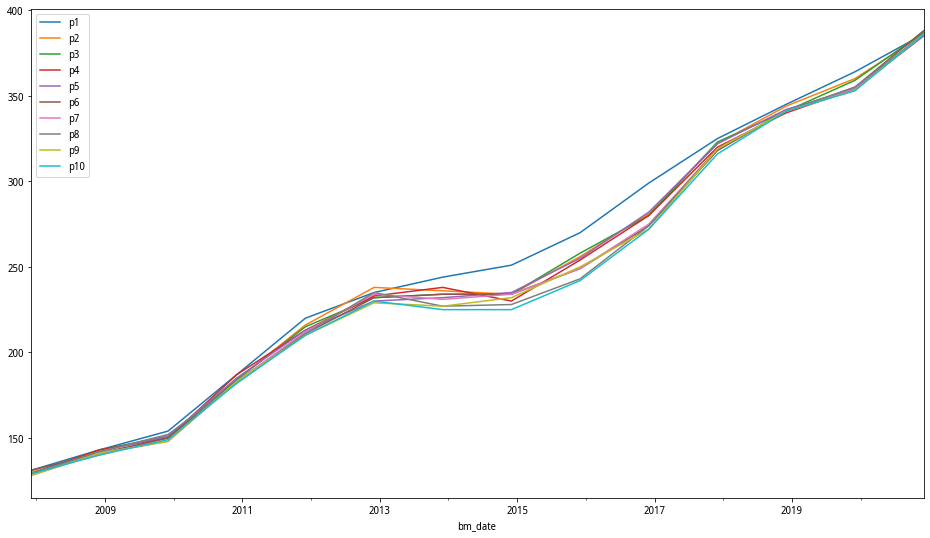

In [108]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('bm_date')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [109]:
portfolios['p1'].groupby('bm_date')['mkt_cap'].mean()

bm_date
2007-12    5.706619e+09
2008-12    8.227056e+09
2009-12    1.075207e+10
2010-12    1.005489e+10
2011-12    8.741191e+09
2012-12    8.194154e+09
2013-12    1.103450e+10
2014-12    1.218596e+10
2015-12    9.465394e+09
2016-12    8.392424e+09
2017-12    1.834939e+10
2018-12    2.199718e+10
2019-12    4.071181e+10
2020-12    5.329208e+10
Freq: M, Name: mkt_cap, dtype: float64

p1            p2            p3            p4            p5  \
bm_date                                                                         
2007-12  5.706619e+09  4.911335e+09  2.866614e+09  3.460573e+09  3.851105e+09   
2008-12  8.227056e+09  9.172598e+09  6.741681e+09  6.799605e+09  7.385338e+09   
2009-12  1.075207e+10  8.386681e+09  7.244166e+09  8.660869e+09  9.323876e+09   
2010-12  1.005489e+10  6.828459e+09  5.520862e+09  5.784589e+09  5.764629e+09   
2011-12  8.741191e+09  5.438506e+09  5.641143e+09  8.411833e+09  1.336214e+10   
2012-12  8.194154e+09  7.163417e+09  5.999376e+09  6.460852e+09  8.990263e+09   
2013-12  1.103450e+10  1.079584e+10  8.969574e+09  9.696426e+09  8.587579e+09   
2014-12  1.218596e+10  1.393161e+10  1.272978e+10  1.130383e+10  1.299155e+10   
2015-12  9.465394e+09  9.605355e+09  1.032111e+10  1.034439e+10  9.517314e+09   
2016-12  8.392424e+09  1.401615e+10  8.367526e+09  1.028523e+10  1.015263e+10   
2017-12  1.834939e+10  9.165983e+09  7.452655e+09  8.748445e+09  9.213470e+09   
2018-12  2.199718e+10  1.315502e+10  8.359079e+09  8.477248e+09  1.030374e+10   
2019-12  4.071181e+10  1.919050e+10  1.226861e+10  8.960314e+09  1.354804e+10   
2020-12  5.329208e+10  1.657290e+10  1.361160e+10  1.068867e+10  8.485962e+09   

                   p6            p7            p8            p9           p10  
bm_date                                                                        
2007-12  2.821432e+09  2.637720e+09  2.310642e+09  1.689852e+09  9.742372e+09  
2008-12  5.752056e+09  5.960823e+09  5.320634e+09  7.748789e+09  2.501994e+10  
2009-12  1.332688e+10  1.392993e+10  1.196730e+10  4.355061e+09  2.371436e+10  
2010-12  2.088759e+10  1.088951e+10  1.564439e+10  6.728626e+09  7.476185e+09  
2011-12  1.451525e+10  1.386424e+10  7.415260e+09  3.982197e+09  4.369501e+09  
2012-12  1.401125e+10  1.402987e+10  4.871112e+09  6.351771e+09  7.127844e+09  
2013-12  7.489063e+09  1.499810e+10  1.838815e+10  2.525351e+10  2.198157e+10  
2014-12  1.077122e+10  1.059753e+10  2.056093e+10  1.710194e+10  3.281785e+10  
2015-12  1.077515e+10  1.031216e+10  9.019756e+09  1.745588e+10  5.153994e+10  
2016-12  9.388335e+09  1.014632e+10  1.207779e+10  1.800722e+10  5.309341e+10  
2017-12  9.836744e+09  7.602803e+09  1.089099e+10  1.242159e+10  2.637575e+10  
2018-12  9.061505e+09  1.226731e+10  1.466307e+10  1.118460e+10  2.363212e+10  
2019-12  1.325247e+10  1.566415e+10  1.099631e+10  1.183646e+10  2.546294e+10  
2020-12  1.220237e+10  1.378971e+10  1.108452e+10  1.151842e+10  2.683413e+10

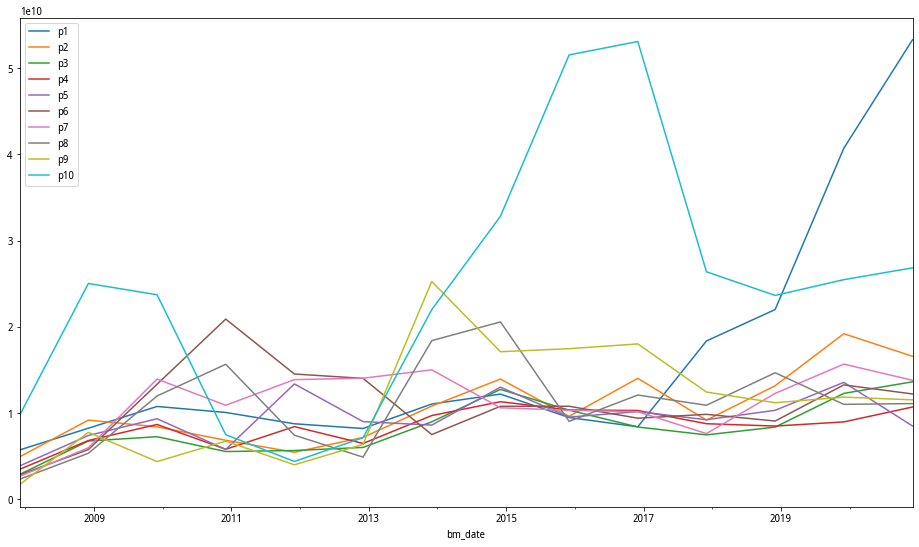

In [110]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('bm_date')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

In [111]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

1.6221765578692882
1.0595311136471859
0.8292412377865788
0.8434491366325018
0.9391259982795449
1.1006523055900357
1.1192155284723835
1.1086489090168263
1.1116850291435363
2.422770766411697


## BM 1年调仓单排结论

排序方法：t年7月至t+1年6月，按照t-1年12月的BM排序，考察区间内每月平均收益率以及区间年平均收益率

结论：
- 月、年平均收益率呈现微弱递增，但p10的收益率较差。年收益的显著性比较强。
- 最大BM组（也即估值最低组）的market cap起伏很大
- 最小BM组（也即估值最高组）的market cap在样本后期显著增大
- BM的效应可能和market cap有关系

## BM Point-in-Time

In [112]:
del portfolios, portfolios_crs_mean

In [113]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df_pit.pkl')

In [114]:
fundmen_df = pd.read_pickle('./data/fundmen_df_pit.pkl')

In [115]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [116]:
fundmen_df.sort_values(['secID','publishDate','endDate'],inplace=True)

In [117]:
fundmen_df = fundmen_df.groupby(['secID','publishDate'],as_index=False).last()

In [118]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
1       000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
2       000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
3       000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
4       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
5       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
6       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
7       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
...             ...         ...        ...         ...                  ...   
176643  900957.XSHG  2020-04-25 2019-12-31  2019-12-31  2020-04-24 16:29:07   
176644  900957.XSHG  2020-04-29 2020-03-31  2020-03-31  2020-04-28 16:20:18   
176645  900957.XSHG  2020-08-12 2020-06-30  2020-06-30  2020-08-11 15:34:09   
176646  900957.XSHG  2020-10-29 2020-09-30  2020-09-30  2020-10-28 15:44:36   
176647  900957.XSHG  2021-04-09 2020-12-31  2020-12-31  2021-04-08 18:13:16   
176648  900957.XSHG  2021-04-27 2021-03-31  2021-03-31  2021-04-26 16:30:45   
176649  900957.XSHG  2021-08-12 2021-06-30  2021-06-30  2021-08-11 16:03:10   
176650  900957.XSHG  2021-10-29 2021-09-30  2021-09-30  2021-10-28 15:35:42   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                 3  7.106094e+09  7.106094e+09          NaN  
1                 6  7.698478e+09  7.698478e+09          NaN  
2                 9  8.363553e+09  8.363553e+09          NaN  
3                12  1.300606e+10  1.300606e+10          NaN  
4                 3  1.404138e+10  1.404138e+10          NaN  
5                 6  1.694330e+10  1.694330e+10          NaN  
6                 9  1.837466e+10  1.837466e+10          NaN  
7                12  1.640079e+10  1.640079e+10          NaN  
...             ...           ...           ...          ...  
176643           12  4.768689e+08  4.761021e+08    766770.50  
176644            3  4.790251e+08  4.782593e+08    765868.18  
176645            6  4.879662e+08  4.871592e+08    807021.03  
176646            9  4.936938e+08  4.928884e+08    805424.48  
176647           12  4.987276e+08  4.979110e+08    816555.06  
176648            3  5.070935e+08  5.062701e+08    823373.23  
176649            6  5.136414e+08  5.128208e+08    820511.29  
176650            9  5.197039e+08  5.188844e+08    819528.99  

[176651 rows x 9 columns]

In [119]:
fundmen_df = fundmen_df[(fundmen_df['secID'].str.endswith('XSHE')) | (fundmen_df['secID'].str.endswith('XSHG'))]

In [120]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [121]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [122]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
1       000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
2       000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
3       000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
4       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
5       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
6       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
7       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
...             ...         ...        ...         ...                  ...   
176643  900957.XSHG  2020-04-25 2019-12-31  2019-12-31  2020-04-24 16:29:07   
176644  900957.XSHG  2020-04-29 2020-03-31  2020-03-31  2020-04-28 16:20:18   
176645  900957.XSHG  2020-08-12 2020-06-30  2020-06-30  2020-08-11 15:34:09   
176646  900957.XSHG  2020-10-29 2020-09-30  2020-09-30  2020-10-28 15:44:36   
176647  900957.XSHG  2021-04-09 2020-12-31  2020-12-31  2021-04-08 18:13:16   
176648  900957.XSHG  2021-04-27 2021-03-31  2021-03-31  2021-04-26 16:30:45   
176649  900957.XSHG  2021-08-12 2021-06-30  2021-06-30  2021-08-11 16:03:10   
176650  900957.XSHG  2021-10-29 2021-09-30  2021-09-30  2021-10-28 15:35:42   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt          book  
0                 3  7.106094e+09  7.106094e+09          NaN  7.106094e+09  
1                 6  7.698478e+09  7.698478e+09          NaN  7.698478e+09  
2                 9  8.363553e+09  8.363553e+09          NaN  8.363553e+09  
3                12  1.300606e+10  1.300606e+10          NaN  1.300606e+10  
4                 3  1.404138e+10  1.404138e+10          NaN  1.404138e+10  
5                 6  1.694330e+10  1.694330e+10          NaN  1.694330e+10  
6                 9  1.837466e+10  1.837466e+10          NaN  1.837466e+10  
7                12  1.640079e+10  1.640079e+10          NaN  1.640079e+10  
...             ...           ...           ...          ...           ...  
176643           12  4.768689e+08  4.761021e+08    766770.50  4.761021e+08  
176644            3  4.790251e+08  4.782593e+08    765868.18  4.782593e+08  
176645            6  4.879662e+08  4.871592e+08    807021.03  4.871592e+08  
176646            9  4.936938e+08  4.928884e+08    805424.48  4.928884e+08  
176647           12  4.987276e+08  4.979110e+08    816555.06  4.979110e+08  
176648            3  5.070935e+08  5.062701e+08    823373.23  5.062701e+08  
176649            6  5.136414e+08  5.128208e+08    820511.29  5.128208e+08  
176650            9  5.197039e+08  5.188844e+08    819528.99  5.188844e+08  

[176590 rows x 10 columns]

- ~~考虑到报表公布时间可能在当天收市以后，以及报表解读可能需要时间，把publishDate往后加1~~
- publishDate和 tradeDate merge, 
- publishDate可能是非交易日，所以merge时要outer，左右表格都不丢观测值。
- 接着要把tradeDate为空值的设置为publishDate，便于排序，方便下面填充
- 然后按照secID和tradeDate sort，因为publishDate非交易日的被放到merge表格的最后了。
- 接着 book 空值由上面第一个非空值填充（当时已知的最新的book value）
- 再把 na 都丢弃即可

In [123]:
# fundmen_df['publishDate+1'] = fundmen_df['publishDate'] + dt.timedelta(days=1)

In [124]:
stk_fundmen_df = pd.merge(stk_df, fundmen_df[['secID','publishDate','endDate','book']], 
                          left_on=['secID','tradeDate'], right_on=['secID','publishDate'],
                          how='outer')

In [125]:
stk_fundmen_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0        000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1        000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2        000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3        000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4        000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
5        000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
6        000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
7        000001.XSHE 2007-07-02        870.870     867.073    4.247515e+10   
...              ...        ...            ...         ...             ...   
9592666  900957.XSHG        NaT            NaN         NaN             NaN   
9592667  900957.XSHG        NaT            NaN         NaN             NaN   
9592668  900957.XSHG        NaT            NaN         NaN             NaN   
9592669  900957.XSHG        NaT            NaN         NaN             NaN   
9592670  900957.XSHG        NaT            NaN         NaN             NaN   
9592671  900957.XSHG        NaT            NaN         NaN             NaN   
9592672  900957.XSHG        NaT            NaN         NaN             NaN   
9592673  900957.XSHG        NaT            NaN         NaN             NaN   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
0         4.182345e+09        0.0840  2007-06         NaT        NaT   
1         2.285485e+09        0.0440  2007-06         NaT        NaT   
2         2.761567e+09        0.0510  2007-06         NaT        NaT   
3         2.324186e+09        0.0426  2007-06         NaT        NaT   
4         2.446556e+09        0.0489  2007-06         NaT        NaT   
5         1.617434e+09        0.0336  2007-06         NaT        NaT   
6         1.410758e+09        0.0316  2007-06         NaT        NaT   
7         8.756147e+08        0.0209  2007-07         NaT        NaT   
...                ...           ...      ...         ...        ...   
9592666            NaN           NaN      NaT  2015-04-25 2015-03-31   
9592667            NaN           NaN      NaT  2015-08-15 2015-06-30   
9592668            NaN           NaN      NaT  2016-04-23 2016-03-31   
9592669            NaN           NaN      NaT  2016-08-06 2016-06-30   
9592670            NaN           NaN      NaT  2017-03-25 2016-12-31   
9592671            NaN           NaN      NaT  2019-03-30 2018-12-31   
9592672            NaN           NaN      NaT  2019-08-10 2019-06-30   
9592673            NaN           NaN      NaT  2020-04-25 2019-12-31   

                 book  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
...               ...  
9592666  3.938849e+08  
9592667  3.952715e+08  
9592668  4.005150e+08  
9592669  3.906354e+08  
9592670  3.930721e+08  
9592671  4.508051e+08  
9592672  4.618426e+08  
9592673  4.761021e+08  

[9592674 rows x 11 columns]

In [126]:
idx = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna()].index

In [127]:
stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'tradeDate'] = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'publishDate']

In [128]:
stk_fundmen_df.loc[idx]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
9535739  000001.XSHE 2007-04-26            NaN         NaN             NaN   
9535740  000001.XSHE 2010-08-25            NaN         NaN             NaN   
9535741  000001.XSHE 2017-04-22            NaN         NaN             NaN   
9535742  000001.XSHE 2017-10-21            NaN         NaN             NaN   
9535743  000002.XSHE 2007-08-28            NaN         NaN             NaN   
9535744  000002.XSHE 2010-08-10            NaN         NaN             NaN   
9535745  000002.XSHE 2016-03-14            NaN         NaN             NaN   
9535746  000002.XSHE 2016-04-28            NaN         NaN             NaN   
...              ...        ...            ...         ...             ...   
9592666  900957.XSHG 2015-04-25            NaN         NaN             NaN   
9592667  900957.XSHG 2015-08-15            NaN         NaN             NaN   
9592668  900957.XSHG 2016-04-23            NaN         NaN             NaN   
9592669  900957.XSHG 2016-08-06            NaN         NaN             NaN   
9592670  900957.XSHG 2017-03-25            NaN         NaN             NaN   
9592671  900957.XSHG 2019-03-30            NaN         NaN             NaN   
9592672  900957.XSHG 2019-08-10            NaN         NaN             NaN   
9592673  900957.XSHG 2020-04-25            NaN         NaN             NaN   

         turnoverValue  turnoverRate   ym publishDate    endDate          book  
9535739            NaN           NaN  NaT  2007-04-26 2007-03-31  7.106094e+09  
9535740            NaN           NaN  NaT  2010-08-25 2010-06-30  3.042111e+10  
9535741            NaN           NaN  NaT  2017-04-22 2017-03-31  2.077390e+11  
9535742            NaN           NaN  NaT  2017-10-21 2017-09-30  2.181110e+11  
9535743            NaN           NaN  NaT  2007-08-28 2007-06-30  1.581408e+10  
9535744            NaN           NaN  NaT  2010-08-10 2010-06-30  3.977295e+10  
9535745            NaN           NaN  NaT  2016-03-14 2015-12-31  1.001835e+11  
9535746            NaN           NaN  NaT  2016-04-28 2016-03-31  1.006367e+11  
...                ...           ...  ...         ...        ...           ...  
9592666            NaN           NaN  NaT  2015-04-25 2015-03-31  3.938849e+08  
9592667            NaN           NaN  NaT  2015-08-15 2015-06-30  3.952715e+08  
9592668            NaN           NaN  NaT  2016-04-23 2016-03-31  4.005150e+08  
9592669            NaN           NaN  NaT  2016-08-06 2016-06-30  3.906354e+08  
9592670            NaN           NaN  NaT  2017-03-25 2016-12-31  3.930721e+08  
9592671            NaN           NaN  NaT  2019-03-30 2018-12-31  4.508051e+08  
9592672            NaN           NaN  NaT  2019-08-10 2019-06-30  4.618426e+08  
9592673            NaN           NaN  NaT  2020-04-25 2019-12-31  4.761021e+08  

[56935 rows x 11 columns]

In [129]:
stk_fundmen_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0        000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1        000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2        000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3        000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4        000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
5        000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
6        000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
7        000001.XSHE 2007-07-02        870.870     867.073    4.247515e+10   
...              ...        ...            ...         ...             ...   
9592666  900957.XSHG 2015-04-25            NaN         NaN             NaN   
9592667  900957.XSHG 2015-08-15            NaN         NaN             NaN   
9592668  900957.XSHG 2016-04-23            NaN         NaN             NaN   
9592669  900957.XSHG 2016-08-06            NaN         NaN             NaN   
9592670  900957.XSHG 2017-03-25            NaN         NaN             NaN   
9592671  900957.XSHG 2019-03-30            NaN         NaN             NaN   
9592672  900957.XSHG 2019-08-10            NaN         NaN             NaN   
9592673  900957.XSHG 2020-04-25            NaN         NaN             NaN   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
0         4.182345e+09        0.0840  2007-06         NaT        NaT   
1         2.285485e+09        0.0440  2007-06         NaT        NaT   
2         2.761567e+09        0.0510  2007-06         NaT        NaT   
3         2.324186e+09        0.0426  2007-06         NaT        NaT   
4         2.446556e+09        0.0489  2007-06         NaT        NaT   
5         1.617434e+09        0.0336  2007-06         NaT        NaT   
6         1.410758e+09        0.0316  2007-06         NaT        NaT   
7         8.756147e+08        0.0209  2007-07         NaT        NaT   
...                ...           ...      ...         ...        ...   
9592666            NaN           NaN      NaT  2015-04-25 2015-03-31   
9592667            NaN           NaN      NaT  2015-08-15 2015-06-30   
9592668            NaN           NaN      NaT  2016-04-23 2016-03-31   
9592669            NaN           NaN      NaT  2016-08-06 2016-06-30   
9592670            NaN           NaN      NaT  2017-03-25 2016-12-31   
9592671            NaN           NaN      NaT  2019-03-30 2018-12-31   
9592672            NaN           NaN      NaT  2019-08-10 2019-06-30   
9592673            NaN           NaN      NaT  2020-04-25 2019-12-31   

                 book  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
...               ...  
9592666  3.938849e+08  
9592667  3.952715e+08  
9592668  4.005150e+08  
9592669  3.906354e+08  
9592670  3.930721e+08  
9592671  4.508051e+08  
9592672  4.618426e+08  
9592673  4.761021e+08  

[9592674 rows x 11 columns]

In [130]:
stk_fundmen_df.sort_values(['secID','tradeDate'],inplace=True)

In [131]:
stk_fundmen_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
9535739  000001.XSHE 2007-04-26            NaN         NaN             NaN   
0        000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1        000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2        000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3        000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4        000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
5        000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
6        000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...              ...        ...            ...         ...             ...   
9535731  900957.XSHG 2022-03-03          0.610       0.614    1.120560e+08   
9535732  900957.XSHG 2022-03-04          0.614       0.611    1.115040e+08   
9535733  900957.XSHG 2022-03-07          0.611       0.605    1.104000e+08   
9535734  900957.XSHG 2022-03-08          0.605       0.604    1.102160e+08   
9535735  900957.XSHG 2022-03-09          0.604       0.600    1.094800e+08   
9535736  900957.XSHG 2022-03-10          0.600       0.605    1.104000e+08   
9535737  900957.XSHG 2022-03-11          0.605       0.606    1.105840e+08   
9535738  900957.XSHG 2022-03-14          0.606       0.594    1.083760e+08   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
9535739            NaN           NaN      NaT  2007-04-26 2007-03-31   
0         4.182345e+09        0.0840  2007-06         NaT        NaT   
1         2.285485e+09        0.0440  2007-06         NaT        NaT   
2         2.761567e+09        0.0510  2007-06         NaT        NaT   
3         2.324186e+09        0.0426  2007-06         NaT        NaT   
4         2.446556e+09        0.0489  2007-06         NaT        NaT   
5         1.617434e+09        0.0336  2007-06         NaT        NaT   
6         1.410758e+09        0.0316  2007-06         NaT        NaT   
...                ...           ...      ...         ...        ...   
9535731   4.576100e+04        0.0004  2022-03         NaT        NaT   
9535732   3.987800e+04        0.0004  2022-03         NaT        NaT   
9535733   1.825430e+05        0.0016  2022-03         NaT        NaT   
9535734   1.612110e+05        0.0015  2022-03         NaT        NaT   
9535735   1.285010e+05        0.0012  2022-03         NaT        NaT   
9535736   7.845200e+04        0.0007  2022-03         NaT        NaT   
9535737   7.993400e+04        0.0007  2022-03         NaT        NaT   
9535738   1.005700e+05        0.0009  2022-03         NaT        NaT   

                 book  
9535739  7.106094e+09  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
...               ...  
9535731           NaN  
9535732           NaN  
9535733           NaN  
9535734           NaN  
9535735           NaN  
9535736           NaN  
9535737           NaN  
9535738           NaN  

[9592674 rows x 11 columns]

In [132]:
temp = stk_fundmen_df[stk_fundmen_df['secID']=='000001.XSHE'].copy()
temp

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
9535739  000001.XSHE 2007-04-26            NaN         NaN             NaN   
0        000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1        000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2        000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3        000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4        000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
5        000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
6        000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...              ...        ...            ...         ...             ...   
3490     000001.XSHE 2022-03-03       2015.361    2019.217    3.048644e+11   
3491     000001.XSHE 2022-03-04       2019.217    1970.375    2.974902e+11   
3492     000001.XSHE 2022-03-07       1970.375    1891.971    2.856527e+11   
3493     000001.XSHE 2022-03-08       1891.971    1839.274    2.776963e+11   
3494     000001.XSHE 2022-03-09       1839.274    1778.864    2.685756e+11   
3495     000001.XSHE 2022-03-10       1778.864    1872.692    2.827385e+11   
3496     000001.XSHE 2022-03-11       1872.692    1915.107    2.891423e+11   
3497     000001.XSHE 2022-03-14       1915.107    1862.409    2.811860e+11   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
9535739            NaN           NaN      NaT  2007-04-26 2007-03-31   
0         4.182345e+09        0.0840  2007-06         NaT        NaT   
1         2.285485e+09        0.0440  2007-06         NaT        NaT   
2         2.761567e+09        0.0510  2007-06         NaT        NaT   
3         2.324186e+09        0.0426  2007-06         NaT        NaT   
4         2.446556e+09        0.0489  2007-06         NaT        NaT   
5         1.617434e+09        0.0336  2007-06         NaT        NaT   
6         1.410758e+09        0.0316  2007-06         NaT        NaT   
...                ...           ...      ...         ...        ...   
3490      9.081716e+08        0.0030  2022-03         NaT        NaT   
3491      1.523794e+09        0.0051  2022-03         NaT        NaT   
3492      1.655960e+09        0.0057  2022-03         NaT        NaT   
3493      1.463146e+09        0.0052  2022-03         NaT        NaT   
3494      2.492043e+09        0.0093  2022-03         NaT        NaT   
3495      3.269868e+09        0.0116  2022-03         NaT        NaT   
3496      2.187481e+09        0.0077  2022-03         NaT        NaT   
3497      1.637278e+09        0.0058  2022-03         NaT        NaT   

                 book  
9535739  7.106094e+09  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
...               ...  
3490              NaN  
3491              NaN  
3492              NaN  
3493              NaN  
3494              NaN  
3495              NaN  
3496              NaN  
3497              NaN  

[3502 rows x 11 columns]

In [133]:
temp[~temp['book'].isna()]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
9535739  000001.XSHE 2007-04-26            NaN         NaN             NaN   
39       000001.XSHE 2007-08-16       1202.510    1147.131    5.619431e+10   
82       000001.XSHE 2007-10-23       1259.787    1300.609    6.371272e+10   
181      000001.XSHE 2008-03-20        855.048     917.705    5.094780e+10   
205      000001.XSHE 2008-04-24        790.808     869.921    4.829500e+10   
286      000001.XSHE 2008-08-21        659.798     639.545    4.328991e+10   
325      000001.XSHE 2008-10-24        396.828     380.689    2.576831e+10   
421      000001.XSHE 2009-03-20        651.507     632.527    4.268801e+10   
...              ...        ...            ...         ...             ...   
2992     000001.XSHE 2020-02-14       1836.953    1884.601    2.916685e+11   
3038     000001.XSHE 2020-04-21       1628.807    1686.486    2.610074e+11   
3126     000001.XSHE 2020-08-28       1844.052    1929.496    2.936090e+11   
3159     000001.XSHE 2020-10-22       2284.023    2239.389    3.407650e+11   
3231     000001.XSHE 2021-02-02       3130.808    2968.848    4.517660e+11   
3281     000001.XSHE 2021-04-21       2766.079    2934.415    4.465264e+11   
3364     000001.XSHE 2021-08-20       2614.314    2496.066    3.768598e+11   
3401     000001.XSHE 2021-10-21       2472.930    2570.613    3.881151e+11   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
9535739            NaN           NaN      NaT  2007-04-26 2007-03-31   
39        1.417128e+09        0.0249  2007-08  2007-08-16 2007-06-30   
82        6.932570e+08        0.0110  2007-10  2007-10-23 2007-09-30   
181       1.326191e+09        0.0273  2008-03  2008-03-20 2007-12-31   
205       1.348041e+09        0.0282  2008-04  2008-04-24 2008-03-31   
286       1.703450e+08        0.0039  2008-08  2008-08-21 2008-06-30   
325       3.505822e+08        0.0134  2008-10  2008-10-24 2008-09-30   
421       9.747196e+08        0.0229  2009-03  2009-03-20 2008-12-31   
...                ...           ...      ...         ...        ...   
2992      2.253906e+09        0.0078  2020-02  2020-02-14 2019-12-31   
3038      2.861879e+09        0.0109  2020-04  2020-04-21 2020-03-31   
3126      3.599036e+09        0.0124  2020-08  2020-08-28 2020-06-30   
3159      3.342069e+09        0.0097  2020-10  2020-10-22 2020-09-30   
3231      5.679180e+09        0.0125  2021-02  2021-02-02 2020-12-31   
3281      3.644578e+09        0.0082  2021-04  2021-04-21 2021-03-31   
3364      3.119153e+09        0.0083  2021-08  2021-08-20 2021-06-30   
3401      3.198266e+09        0.0084  2021-10  2021-10-21 2021-09-30   

                 book  
9535739  7.106094e+09  
39       7.698478e+09  
82       8.363553e+09  
181      1.300606e+10  
205      1.404138e+10  
286      1.694330e+10  
325      1.837466e+10  
421      1.640079e+10  
...               ...  
2992     3.129830e+11  
3038     3.523550e+11  
3126     3.513970e+11  
3159     3.587710e+11  
3231     3.641310e+11  
3281     3.726170e+11  
3364     3.771930e+11  
3401     3.888580e+11  

[59 rows x 11 columns]

In [134]:
stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

publishDate    endDate          book
9535739  2007-04-26 2007-03-31  7.106094e+09
0        2007-04-26 2007-03-31  7.106094e+09
1        2007-04-26 2007-03-31  7.106094e+09
2        2007-04-26 2007-03-31  7.106094e+09
3        2007-04-26 2007-03-31  7.106094e+09
4        2007-04-26 2007-03-31  7.106094e+09
5        2007-04-26 2007-03-31  7.106094e+09
6        2007-04-26 2007-03-31  7.106094e+09
...             ...        ...           ...
9535731  2021-10-29 2021-09-30  5.188844e+08
9535732  2021-10-29 2021-09-30  5.188844e+08
9535733  2021-10-29 2021-09-30  5.188844e+08
9535734  2021-10-29 2021-09-30  5.188844e+08
9535735  2021-10-29 2021-09-30  5.188844e+08
9535736  2021-10-29 2021-09-30  5.188844e+08
9535737  2021-10-29 2021-09-30  5.188844e+08
9535738  2021-10-29 2021-09-30  5.188844e+08

[9592674 rows x 3 columns]

In [135]:
stk_fundmen_df.loc[:,['publishDate','endDate','book']] = stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

In [136]:
## 查看数据
idx = pd.IndexSlice
stk_fundmen_df.set_index(['secID','tradeDate'],inplace=True)
pd.options.display.max_rows = 20

In [137]:
stk_fundmen_df.loc[idx['000001.XSHE','2010-03'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                               
000001.XSHE 2010-03-02        926.303     953.535    6.757628e+10   
            2010-03-03        953.535     961.374    6.813186e+10   
            2010-03-04        961.374     953.122    6.754704e+10   
            2010-03-05        953.122     960.137    6.804414e+10   
            2010-03-08        960.137     984.068    6.974013e+10   
            2010-03-09        984.068     982.830    6.965240e+10   
            2010-03-10        982.830     965.500    6.842427e+10   
            2010-03-11        965.500     976.228    6.918454e+10   
            2010-03-12        976.228     945.695    6.702070e+10   
            2010-03-15        945.695     923.827    6.547092e+10   
...                               ...         ...             ...   
            2010-03-18        956.836     951.059    6.740083e+10   
            2010-03-19        951.059     950.647    6.737159e+10   
            2010-03-22        950.647     955.185    6.769325e+10   
            2010-03-23        955.185     941.982    6.675753e+10   
            2010-03-24        941.982     940.744    6.666981e+10   
            2010-03-25        940.744     920.114    6.520775e+10   
            2010-03-26        920.114     941.157    6.669905e+10   
            2010-03-29        941.157     972.102    6.889213e+10   
            2010-03-30        972.102     975.816    6.915530e+10   
            2010-03-31        975.816     957.248    6.783945e+10   

                        turnoverValue  turnoverRate       ym publishDate  \
secID       tradeDate                                                      
000001.XSHE 2010-03-02   1.599220e+09        0.0234  2010-03  2009-10-29   
            2010-03-03   6.554447e+08        0.0097  2010-03  2009-10-29   
            2010-03-04   8.773898e+08        0.0129  2010-03  2009-10-29   
            2010-03-05   6.811939e+08        0.0100  2010-03  2009-10-29   
            2010-03-08   1.045699e+09        0.0151  2010-03  2009-10-29   
            2010-03-09   9.439663e+08        0.0135  2010-03  2009-10-29   
            2010-03-10   4.993564e+08        0.0072  2010-03  2009-10-29   
            2010-03-11   5.714539e+08        0.0082  2010-03  2009-10-29   
            2010-03-12   6.559102e+08        0.0097  2010-03  2010-03-12   
            2010-03-15   4.248571e+08        0.0065  2010-03  2010-03-12   
...                               ...           ...      ...         ...   
            2010-03-18   5.075273e+08        0.0075  2010-03  2010-03-12   
            2010-03-19   4.042847e+08        0.0060  2010-03  2010-03-12   
            2010-03-22   4.531987e+08        0.0067  2010-03  2010-03-12   
            2010-03-23   3.655600e+08        0.0054  2010-03  2010-03-12   
            2010-03-24   4.843363e+08        0.0072  2010-03  2010-03-12   
            2010-03-25   3.721843e+08        0.0057  2010-03  2010-03-12   
            2010-03-26   5.091492e+08        0.0076  2010-03  2010-03-12   
            2010-03-29   1.044826e+09        0.0152  2010-03  2010-03-12   
            2010-03-30   5.954468e+08        0.0087  2010-03  2010-03-12   
            2010-03-31   7.105142e+08        0.0104  2010-03  2010-03-12   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2010-03-02 2009-09-30  1.908844e+10  
            2010-03-03 2009-09-30  1.908844e+10  
            2010-03-04 2009-09-30  1.908844e+10  
            2010-03-05 2009-09-30  1.908844e+10  
            2010-03-08 2009-09-30  1.908844e+10  
            2010-03-09 2009-09-30  1.908844e+10  
            2010-03-10 2009-09-30  1.908844e+10  
            2010-03-11 2009-09-30  1.908844e+10  
            2010-03-12 2009-12-31  2.046961e+10  
            2010-03-15 2009-12-31  2.046961e+10  
...                           ...           ...  
            2010-03-18 2009-12-31  2.

In [138]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                               
000001.XSHE 2007-04-26            NaN         NaN             NaN   

                        turnoverValue  turnoverRate   ym publishDate  \
secID       tradeDate                                                  
000001.XSHE 2007-04-26            NaN           NaN  NaT  2007-04-26   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2007-04-26 2007-03-31  7.106094e+09

In [139]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04':'2007-06'],:]

preClosePrice  closePrice  negMarketValue  \
secID       tradeDate                                               
000001.XSHE 2007-04-26            NaN         NaN             NaN   
            2007-06-20        824.193     987.007    4.835036e+10   
            2007-06-21        987.007    1085.740    5.318694e+10   
            2007-06-22       1085.740    1120.233    5.487665e+10   
            2007-06-25       1120.233    1113.904    5.456661e+10   
            2007-06-27       1113.904    1019.602    4.994705e+10   
            2007-06-28       1019.602     953.780    4.672266e+10   
            2007-06-29        953.780     870.870    4.266117e+10   

                        turnoverValue  turnoverRate       ym publishDate  \
secID       tradeDate                                                      
000001.XSHE 2007-04-26            NaN           NaN      NaT  2007-04-26   
            2007-06-20   4.182345e+09        0.0840  2007-06  2007-04-26   
            2007-06-21   2.285485e+09        0.0440  2007-06  2007-04-26   
            2007-06-22   2.761567e+09        0.0510  2007-06  2007-04-26   
            2007-06-25   2.324186e+09        0.0426  2007-06  2007-04-26   
            2007-06-27   2.446556e+09        0.0489  2007-06  2007-04-26   
            2007-06-28   1.617434e+09        0.0336  2007-06  2007-04-26   
            2007-06-29   1.410758e+09        0.0316  2007-06  2007-04-26   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2007-04-26 2007-03-31  7.106094e+09  
            2007-06-20 2007-03-31  7.106094e+09  
            2007-06-21 2007-03-31  7.106094e+09  
            2007-06-22 2007-03-31  7.106094e+09  
            2007-06-25 2007-03-31  7.106094e+09  
            2007-06-27 2007-03-31  7.106094e+09  
            2007-06-28 2007-03-31  7.106094e+09  
            2007-06-29 2007-03-31  7.106094e+09

In [140]:
stk_fundmen_df.reset_index(inplace=True)

In [141]:
stk_fundmen_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0        000001.XSHE 2007-04-26            NaN         NaN             NaN   
1        000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
2        000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
3        000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
4        000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
5        000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
6        000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
7        000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
8        000001.XSHE 2007-07-02        870.870     867.073    4.247515e+10   
9        000001.XSHE 2007-07-03        867.073     861.693    4.221161e+10   
...              ...        ...            ...         ...             ...   
9592664  900957.XSHG 2022-03-01          0.615       0.616    1.124240e+08   
9592665  900957.XSHG 2022-03-02          0.616       0.610    1.113200e+08   
9592666  900957.XSHG 2022-03-03          0.610       0.614    1.120560e+08   
9592667  900957.XSHG 2022-03-04          0.614       0.611    1.115040e+08   
9592668  900957.XSHG 2022-03-07          0.611       0.605    1.104000e+08   
9592669  900957.XSHG 2022-03-08          0.605       0.604    1.102160e+08   
9592670  900957.XSHG 2022-03-09          0.604       0.600    1.094800e+08   
9592671  900957.XSHG 2022-03-10          0.600       0.605    1.104000e+08   
9592672  900957.XSHG 2022-03-11          0.605       0.606    1.105840e+08   
9592673  900957.XSHG 2022-03-14          0.606       0.594    1.083760e+08   

         turnoverValue  turnoverRate       ym publishDate    endDate  \
0                  NaN           NaN      NaT  2007-04-26 2007-03-31   
1         4.182345e+09        0.0840  2007-06  2007-04-26 2007-03-31   
2         2.285485e+09        0.0440  2007-06  2007-04-26 2007-03-31   
3         2.761567e+09        0.0510  2007-06  2007-04-26 2007-03-31   
4         2.324186e+09        0.0426  2007-06  2007-04-26 2007-03-31   
5         2.446556e+09        0.0489  2007-06  2007-04-26 2007-03-31   
6         1.617434e+09        0.0336  2007-06  2007-04-26 2007-03-31   
7         1.410758e+09        0.0316  2007-06  2007-04-26 2007-03-31   
8         8.756147e+08        0.0209  2007-07  2007-04-26 2007-03-31   
9         6.936451e+08        0.0163  2007-07  2007-04-26 2007-03-31   
...                ...           ...      ...         ...        ...   
9592664   1.150660e+05        0.0010  2022-03  2021-10-29 2021-09-30   
9592665   1.003980e+05        0.0009  2022-03  2021-10-29 2021-09-30   
9592666   4.576100e+04        0.0004  2022-03  2021-10-29 2021-09-30   
9592667   3.987800e+04        0.0004  2022-03  2021-10-29 2021-09-30   
9592668   1.825430e+05        0.0016  2022-03  2021-10-29 2021-09-30   
9592669   1.612110e+05        0.0015  2022-03  2021-10-29 2021-09-30   
9592670   1.285010e+05        0.0012  2022-03  2021-10-29 2021-09-30   
9592671   7.845200e+04        0.0007  2022-03  2021-10-29 2021-09-30   
9592672   7.993400e+04        0.0007  2022-03  2021-10-29 2021-09-30   
9592673   1.005700e+05        0.0009  2022-03  2021-10-29 2021-09-30   

                 book  
0        7.106094e+09  
1        7.106094e+09  
2        7.106094e+09  
3        7.106094e+09  
4        7.106094e+09  
5        7.106094e+09  
6        7.106094e+09  
7        7.106094e+09  
8        7.106094e+09  
9        7.106094e+09  
...               ...  
9592664  5.188844e+08  
9592665  5.188844e+08  
9592666  5.188844e+08  
9592667  5.188844e+08  
9592668  5.188844e+08  
9592669  5.188844e+08  
9592670  5.188844e+08  
9592671  5.188844e+08  
9592672  5.188844e+08  
9592673  5.188844e+08  

[9592674 rows x 11 columns]

In [142]:
stk_df_m = stk_fundmen_df.groupby(['secID','ym'],as_index=False).last()

stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [143]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
8       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
9       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
...             ...      ...        ...            ...         ...   
484443  900957.XSHG  2021-06 2021-06-30          0.633       0.639   
484444  900957.XSHG  2021-07 2021-07-30          0.651       0.650   
484445  900957.XSHG  2021-08 2021-08-31          0.626       0.612   
484446  900957.XSHG  2021-09 2021-09-30          0.655       0.667   
484447  900957.XSHG  2021-10 2021-10-29          0.636       0.640   
484448  900957.XSHG  2021-11 2021-11-30          0.623       0.614   
484449  900957.XSHG  2021-12 2021-12-31          0.635       0.636   
484450  900957.XSHG  2022-01 2022-01-28          0.617       0.622   
484451  900957.XSHG  2022-02 2022-02-28          0.616       0.615   
484452  900957.XSHG  2022-03 2022-03-14          0.606       0.594   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
0         4.266117e+10   1.410758e+09        0.0316  2007-04-26 2007-03-31   
1         5.616330e+10   1.479466e+09        0.0270  2007-04-26 2007-03-31   
2         5.890714e+10   6.552881e+08        0.0112  2007-08-16 2007-06-30   
3         6.197651e+10   1.408136e+09        0.0228  2007-08-16 2007-06-30   
4         7.448652e+10   1.440425e+09        0.0200  2007-10-23 2007-09-30   
5         5.593078e+10   5.452159e+08        0.0096  2007-10-23 2007-09-30   
6         6.574629e+10   1.019671e+09        0.0154  2007-10-23 2007-09-30   
7         5.850212e+10   5.328429e+08        0.0089  2007-10-23 2007-09-30   
8         5.823860e+10   2.267900e+08        0.0039  2007-10-23 2007-09-30   
9         4.954234e+10   6.155862e+08        0.0123  2008-03-20 2007-12-31   
...                ...            ...           ...         ...        ...   
484443    1.166560e+08   1.610070e+05        0.0014  2021-04-27 2021-03-31   
484444    1.186800e+08   1.151750e+05        0.0010  2021-04-27 2021-03-31   
484445    1.116880e+08   3.033640e+05        0.0027  2021-08-12 2021-06-30   
484446    1.218080e+08   2.086830e+05        0.0017  2021-08-12 2021-06-30   
484447    1.168400e+08   6.162200e+04        0.0005  2021-10-29 2021-09-30   
484448    1.120560e+08   1.161060e+05        0.0010  2021-10-29 2021-09-30   
484449    1.161040e+08   1.059960e+05        0.0009  2021-10-29 2021-09-30   
484450    1.135280e+08   1.319240e+05        0.0012  2021-10-29 2021-09-30   
484451    1.122400e+08   9.851400e+04        0.0009  2021-10-29 2021-09-30   
484452    1.083760e+08   1.005700e+05        0.0009  2021-10-29 2021-09-30   

                book       ret  
0       7.106094e+09       NaN  
1       7.106094e+09  0.316497  
2       7.698478e+09  0.048855  
3       7.698478e+09  0.052105  
4       8.363553e+09  0.201851  
5       8.363553e+09 -0.249116  
6       8.363553e+09  0.069845  
7       8.363553e+09 -0.137306  
8       8.363553e+09 -0.004504  
9       1.300606e+10 -0.149321  
...              ...       ...  
484443  5.062701e+08  0.027331  
484444  5.062701e+08  0.017214  
484445  5.128208e+08 -0.058462  
484446  5.128208e+08  0.089869  
484447  5.188844e+08 -0.040480  
484448  5.188844e+08 -0.040625  
484449  5.188844e+08  0.035831  
484450  5.188844e+08 -0.022013  
484451  5.188844e+08 -0.011254  
484452  5.188844e+08 -0.034146  

[484453 rows x 12 columns]

In [144]:
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

In [145]:
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1]

secID       ym  tradeDate  preClosePrice  closePrice  \
36      000001.XSHE  2010-06 2010-06-29        762.910     722.475   
175     000001.XSHE  2022-03 2022-03-14       1915.107    1862.409   
283     000002.XSHE  2015-12 2015-12-18       2588.816    2847.581   
352     000002.XSHE  2022-03 2022-03-14       2477.354    2394.032   
410     000004.XSHE  2016-03 2016-03-23        228.801     251.694   
417     000004.XSHE  2017-03 2017-03-31        252.788     246.022   
475     000004.XSHE  2022-03 2022-03-14        133.330     132.032   
510     000005.XSHE  2011-04 2011-04-29         37.437      37.929   
543     000005.XSHE  2014-12 2014-12-26         39.304      40.287   
615     000005.XSHE  2021-04 2021-04-29         22.010      21.814   
...             ...      ...        ...            ...         ...   
483607  900951.XSHG  2020-08 2020-08-20          0.070       0.069   
483790  900952.XSHG  2022-03 2022-03-14          0.606       0.581   
483806  900953.XSHG  2008-04 2008-04-29          0.430       0.430   
483959  900953.XSHG  2022-03 2022-03-14          0.342       0.339   
484035  900955.XSHG  2013-04 2013-04-26          1.275       1.251   
484050  900955.XSHG  2015-06 2015-06-01          3.217       3.467   
484104  900955.XSHG  2020-04 2020-04-29          0.563       0.507   
484215  900956.XSHG  2016-03 2016-03-14          1.851       1.913   
484269  900956.XSHG  2020-11 2020-11-04          3.569       3.424   
484452  900957.XSHG  2022-03 2022-03-14          0.606       0.594   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
36        5.437499e+10   5.491348e+08        0.0099  2010-04-29 2010-03-31   
175       2.811860e+11   1.637278e+09        0.0058  2021-10-21 2021-09-30   
283       2.374641e+11   5.288951e+09        0.0230  2015-10-28 2015-09-30   
352       1.563554e+11   1.852414e+09        0.0116  2021-10-29 2021-09-30   
410       3.055487e+09   2.016834e+08        0.0680  2015-10-31 2015-09-30   
417       2.986693e+09   4.408517e+07        0.0146  2016-10-29 2016-09-30   
475       2.247511e+09   8.951660e+07        0.0391  2021-10-27 2021-09-30   
510       3.527048e+09   1.632527e+07        0.0047  2010-10-29 2010-09-30   
543       3.746346e+09   1.534932e+08        0.0411  2014-10-29 2014-09-30   
615       2.348641e+09   1.046951e+07        0.0044  2020-10-29 2020-09-30   
...                ...            ...           ...         ...        ...   
483607    6.900000e+06   4.458600e+04        0.0067  2020-04-25 2020-03-31   
483790    5.726140e+07   2.598340e+05        0.0045  2021-10-29 2021-09-30   
483806    1.000800e+08   5.857590e+05        0.0058  2007-10-20 2007-09-30   
483959    7.896000e+07   1.131410e+05        0.0014  2021-10-30 2021-09-30   
484035    1.188000e+08   1.802100e+05        0.0015  2012-10-31 2012-09-30   
484050    3.293400e+08   3.140139e+06        0.0097  2015-04-25 2015-03-31   
484104    4.818000e+07   2.699610e+05        0.0054  2019-10-31 2019-09-30   
484215    2.051600e+08   3.082141e+06        0.0149  2015-10-29 2015-09-30   
484269    3.530500e+08   8.700989e+06        0.0241  2020-10-29 2020-09-30   
484452    1.083760e+08   1.005700e+05        0.0009  2021-10-29 2021-09-30   

                book       ret ret_date              ym_diff  
36      2.210983e+10 -0.073672  2010-09                    3  
175     3.888580e+11       NaN      NaT  9223372036854775182  
283     8.892608e+10 -0.269035  2016-07                    7  
352     2.276229e+11       NaN      NaT  9223372036854775182  
410     8.273100e+07  0.017108  2016-09                    6  
417     9.622171e+07 -0.287499  2017-06                    3  
475     1.490531e+09       NaN      NaT  9223372036854775182  
510     6.752503e+08  0.028501  2012-04                   12  
543     5.929574e+08  2.858540  2015-05                    5  
615     1.622737e+09       NaN      NaT  9223372036854775193  
...              ...       ...      ...                  ...  


In [146]:
# 停牌删去
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1,'ret'] = np.nan

In [147]:
# 查看数据
temp = stk_df_m['secID'].unique()
display(stk_df_m[stk_df_m['secID'] == np.random.choice(temp,1)[0]])

secID       ym  tradeDate  preClosePrice  closePrice  \
467939  605116.XSHG  2020-09 2020-09-30         17.490      16.520   
467940  605116.XSHG  2020-10 2020-10-30         19.040      17.530   
467941  605116.XSHG  2020-11 2020-11-30         18.350      18.320   
467942  605116.XSHG  2020-12 2020-12-31         15.750      15.870   
467943  605116.XSHG  2021-01 2021-01-29         15.710      14.140   
467944  605116.XSHG  2021-02 2021-02-26         13.650      13.660   
467945  605116.XSHG  2021-03 2021-03-31         15.200      15.160   
467946  605116.XSHG  2021-04 2021-04-30         17.200      17.380   
467947  605116.XSHG  2021-05 2021-05-31         14.430      14.800   
467948  605116.XSHG  2021-06 2021-06-30         14.185      14.135   
467949  605116.XSHG  2021-07 2021-07-30         14.185      14.014   
467950  605116.XSHG  2021-08 2021-08-31         13.762      13.802   
467951  605116.XSHG  2021-09 2021-09-30         13.106      13.449   
467952  605116.XSHG  2021-10 2021-10-29         12.300      12.390   
467953  605116.XSHG  2021-11 2021-11-30         19.730      21.706   
467954  605116.XSHG  2021-12 2021-12-31         20.184      22.200   
467955  605116.XSHG  2022-01 2022-01-28         19.488      21.434   
467956  605116.XSHG  2022-02 2022-02-28         21.978      22.008   
467957  605116.XSHG  2022-03 2022-03-14         23.642      26.011   

        negMarketValue  turnoverValue  turnoverRate publishDate    endDate  \
467939    6.773200e+08    249301778.0        0.3736  2020-09-08 2019-12-31   
467940    7.187300e+08    109638314.0        0.1474  2020-10-29 2020-09-30   
467941    7.511200e+08     39324380.0        0.0522  2020-10-29 2020-09-30   
467942    6.506700e+08     35867084.0        0.0549  2020-10-29 2020-09-30   
467943    5.797400e+08     50687282.0        0.0848  2020-10-29 2020-09-30   
467944    5.600600e+08     11489080.0        0.0205  2020-10-29 2020-09-30   
467945    6.215600e+08     32556596.0        0.0522  2020-10-29 2020-09-30   
467946    7.125800e+08    168984435.0        0.2402  2021-04-29 2021-03-31   
467947    6.068000e+08     19157242.0        0.0319  2021-04-29 2021-03-31   
467948    5.748200e+08      9807849.0        0.0171  2021-04-29 2021-03-31   
467949    5.699000e+08      8463181.0        0.0149  2021-04-29 2021-03-31   
467950    5.612900e+08      9275307.0        0.0166  2021-08-31 2021-06-30   
467951    1.031598e+09      6464580.0        0.0063  2021-08-31 2021-06-30   
467952    9.504004e+08      2981573.0        0.0031  2021-08-31 2021-06-30   
467953    1.664941e+09    454379548.0        0.2922  2021-10-30 2021-09-30   
467954    1.702833e+09    144668088.0        0.0868  2021-10-30 2021-09-30   
467955    1.644061e+09     47306575.0        0.0289  2021-10-30 2021-09-30   
467956    1.688140e+09     70790127.0        0.0421  2021-10-30 2021-09-30   
467957    1.995145e+09    587248355.0        0.2992  2021-10-30 2021-09-30   

                book       ret ret_date              ym_diff  
467939  9.772832e+08  0.061138  2020-10                    1  
467940  1.368126e+09  0.045066  2020-11                    1  
467941  1.368126e+09 -0.133734  2020-12                    1  
467942  1.368126e+09 -0.109011  2021-01                    1  
467943  1.368126e+09 -0.033946  2021-02                    1  
467944  1.368126e+09  0.109810  2021-03                    1  
467945  1.368126e+09  0.146438  2021-04                    1  
467946  1.417570e+09 -0.148446  2021-05                    1  
467947  1.417570e+09 -0.044932  2021-06                    1  
467948  1.417570e+09 -0.008560  2021-07                    1  
467949  1.417570e+09 -0.015128  2021-08                    1  
467950  1.422180e+09 -0.025576  2021-09                    1  
467951  1.422180e+09 -0.078742  2021-10                    1  
467952  1.422180e+09  0.751897  2021-11                    1  
467953  1.471599e+09  0.022759  2021-12                    1  
467954  1.471599e+09 -0.034505  2022-01     

In [148]:
del temp

In [149]:
stk_df_m.drop(['tradeDate','closePrice','publishDate','endDate', 'ym_diff'],axis=1,inplace=True)

stk_df_m.rename(columns={'ym':'mktcap_book_date','negMarketValue':'mktcap'},inplace=True)

stk_df_m.dropna(inplace=True)

stk_df_m

secID mktcap_book_date  preClosePrice        mktcap  \
0       000001.XSHE          2007-06        953.780  4.266117e+10   
1       000001.XSHE          2007-07       1082.259  5.616330e+10   
2       000001.XSHE          2007-08       1193.016  5.890714e+10   
3       000001.XSHE          2007-09       1228.142  6.197651e+10   
4       000001.XSHE          2007-10       1427.189  7.448652e+10   
5       000001.XSHE          2007-11       1172.447  5.593078e+10   
6       000001.XSHE          2007-12       1234.155  6.574629e+10   
7       000001.XSHE          2008-01       1074.347  5.850212e+10   
8       000001.XSHE          2008-02       1037.956  5.823860e+10   
9       000001.XSHE          2008-03        918.971  4.954234e+10   
...             ...              ...            ...           ...   
484442  900957.XSHG          2021-05          0.620  1.135280e+08   
484443  900957.XSHG          2021-06          0.633  1.166560e+08   
484444  900957.XSHG          2021-07          0.651  1.186800e+08   
484445  900957.XSHG          2021-08          0.626  1.116880e+08   
484446  900957.XSHG          2021-09          0.655  1.218080e+08   
484447  900957.XSHG          2021-10          0.636  1.168400e+08   
484448  900957.XSHG          2021-11          0.623  1.120560e+08   
484449  900957.XSHG          2021-12          0.635  1.161040e+08   
484450  900957.XSHG          2022-01          0.617  1.135280e+08   
484451  900957.XSHG          2022-02          0.616  1.122400e+08   

        turnoverValue  turnoverRate          book       ret ret_date  
0        1.410758e+09        0.0316  7.106094e+09  0.316497  2007-07  
1        1.479466e+09        0.0270  7.106094e+09  0.048855  2007-08  
2        6.552881e+08        0.0112  7.698478e+09  0.052105  2007-09  
3        1.408136e+09        0.0228  7.698478e+09  0.201851  2007-10  
4        1.440425e+09        0.0200  8.363553e+09 -0.249116  2007-11  
5        5.452159e+08        0.0096  8.363553e+09  0.069845  2007-12  
6        1.019671e+09        0.0154  8.363553e+09 -0.137306  2008-01  
7        5.328429e+08        0.0089  8.363553e+09 -0.004504  2008-02  
8        2.267900e+08        0.0039  8.363553e+09 -0.149321  2008-03  
9        6.155862e+08        0.0123  1.300606e+10  0.050355  2008-04  
...               ...           ...           ...       ...      ...  
484442   1.458800e+05        0.0013  5.062701e+08  0.027331  2021-06  
484443   1.610070e+05        0.0014  5.062701e+08  0.017214  2021-07  
484444   1.151750e+05        0.0010  5.062701e+08 -0.058462  2021-08  
484445   3.033640e+05        0.0027  5.128208e+08  0.089869  2021-09  
484446   2.086830e+05        0.0017  5.128208e+08 -0.040480  2021-10  
484447   6.162200e+04        0.0005  5.188844e+08 -0.040625  2021-11  
484448   1.161060e+05        0.0010  5.188844e+08  0.035831  2021-12  
484449   1.059960e+05        0.0009  5.188844e+08 -0.022013  2022-01  
484450   1.319240e+05        0.0012  5.188844e+08 -0.011254  2022-02  
484451   9.851400e+04        0.0009  5.188844e+08 -0.034146  2022-03  

[471605 rows x 9 columns]

In [150]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ret_date']>='2010-05') &(stk_df_m['ret_date']<='2010-10')]

secID mktcap_book_date  preClosePrice        mktcap  turnoverValue  \
34  000001.XSHE          2010-04        832.228  6.011979e+10    662829180.0   
35  000001.XSHE          2010-05        745.994  5.120124e+10    480683776.0   
37  000001.XSHE          2010-09        670.899  5.036906e+10    347260768.0   

    turnoverRate          book       ret ret_date  
34        0.0111  2.210983e+10 -0.148346  2010-05  
35        0.0092  2.210983e+10  0.000000  2010-06  
37        0.0069  3.042111e+10  0.135019  2010-10

### Merge

In [151]:
ret_df = pd.merge(stk_df_m, rf, left_on='ret_date',right_on='ym')
ret_df.drop('ym',axis=1,inplace=True)
ret_df['exret'] = ret_df['ret'] - ret_df['rf']
ret_df.sort_values(['secID','ret_date'],inplace=True)
ret_df.reset_index(drop=True,inplace=True)
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mktcap_book_date'],right_on=['secID','ym'])
# display(ret_df)
ret_df.drop(['ym','rf','ret'],axis=1,inplace=True)
ret_df.rename(columns={'mktcap_book_date':'grouping_date'},inplace=True)
ret_df['bm'] = ret_df['book'] / ret_df['mktcap']
ret_df['size'] = np.log(ret_df['mktcap'])
ret_df = ret_df[['secID','grouping_date','size','mktcap','bm',
                 'beta','ret_date','exret']]

In [152]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2007-06  24.476555  4.266117e+10  0.166571  0.4614   
1       000001.XSHE       2007-07  24.751529  5.616330e+10  0.126526  0.6423   
2       000001.XSHE       2007-08  24.799228  5.890714e+10  0.130688  0.7722   
3       000001.XSHE       2007-09  24.850021  6.197651e+10  0.124216  0.7596   
4       000001.XSHE       2007-10  25.033884  7.448652e+10  0.112283  0.7988   
5       000001.XSHE       2007-11  24.747381  5.593078e+10  0.149534  0.9560   
6       000001.XSHE       2007-12  24.909069  6.574629e+10  0.127210  0.9468   
7       000001.XSHE       2008-01  24.792329  5.850212e+10  0.142962  0.9654   
8       000001.XSHE       2008-02  24.787814  5.823860e+10  0.143608  1.0292   
9       000001.XSHE       2008-03  24.626093  4.954234e+10  0.262524  1.0238   
...             ...           ...        ...           ...       ...     ...   
450568  689009.XSHG       2021-04  22.228469  4.505069e+09  0.831319  1.5726   
450569  689009.XSHG       2021-05  22.213574  4.438462e+09  0.843795  1.4696   
450570  689009.XSHG       2021-06  22.363075  5.154186e+09  0.726623  1.3761   
450571  689009.XSHG       2021-07  22.144386  4.141757e+09  0.904242  1.0975   
450572  689009.XSHG       2021-08  22.236499  4.541392e+09  0.885598  1.0727   
450573  689009.XSHG       2021-09  22.312225  4.898648e+09  0.821012  1.0100   
450574  689009.XSHG       2021-10  24.067952  2.835168e+10  0.147515  0.8570   
450575  689009.XSHG       2021-11  24.017317  2.695182e+10  0.155177  0.7546   
450576  689009.XSHG       2021-12  24.158564  3.104066e+10  0.134737  0.5898   
450577  689009.XSHG       2022-01  24.016823  2.693853e+10  0.155254  0.5326   

       ret_date     exret  
0       2007-07  0.313877  
1       2007-08  0.046173  
2       2007-09  0.049171  
3       2007-10  0.198601  
4       2007-11 -0.252661  
5       2007-12  0.066202  
6       2008-01 -0.141037  
7       2008-02 -0.008257  
8       2008-03 -0.153072  
9       2008-04  0.046610  
...         ...       ...  
450568  2021-05 -0.016887  
450569  2021-06  0.159215  
450570  2021-07 -0.198444  
450571  2021-08  0.094522  
450572  2021-09  0.076687  
450573  2021-10 -0.210927  
450574  2021-11 -0.051430  
450575  2021-12  0.149630  
450576  2022-01 -0.134237  
450577  2022-02 -0.063915  

[450578 rows x 8 columns]

## Sorting on BM poin-in-time

In [153]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.003281  0.005831  0.008152  0.008077  0.010777  0.010973  0.012599   
t-value  0.457659  0.828901  1.117207  1.085714  1.455011  1.483172  1.676221   

               p8        p9       p10    p10-p1  
mean     0.013290  0.014335  0.015931  0.012650  
t-value  1.759281  1.830106  1.919376  3.089765

结论：

- 用最新的BM更新portfolio可以带来收益率的递增，但每个portfolio本身的收益率并不显著为正
- p10和p1的差距是显著为正的

### Sorting on BM with data from Uqer

In [154]:
# %%time
# begin_ = 2007
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# pb_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")

In [155]:
# # # 从优矿下载 PB，时间较长。由于优矿的限制，每次下载3年的数据

# pb = {}
# begin_ = 2007
# end_ = 2010
# i = 0
# while end_ <= 2022:
#     if end_ == 2022:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         pb[i] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")
#     else:
#         pb[i] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','PB'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
#     i = i+1
    
# for i in range(4):
#     pb_df = pd.DataFrame(np.vstack([_df for _df in pb.values()]),columns=['secID','tradeDate','PB'])
    
# pb_df.to_pickle('./data/pb_df.pkl')

In [156]:
pb_df = pd.read_pickle('./data/pb_df.pkl')

In [157]:
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])

pb_df['PB'] = pd.to_numeric(pb_df['PB'])

pb_df['grouping_date'] = pb_df['tradeDate'].dt.to_period('M')

pb_df = pb_df.groupby(['secID','grouping_date'],as_index=False).last()

pb_df['bm_uqer'] = 1 / pb_df['PB']

ret_df = pd.merge(ret_df,pb_df[['secID','grouping_date','bm_uqer']],on=['secID','grouping_date'])

del pb_df

In [158]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2007-06  24.476555  4.266117e+10  0.166571  0.4614   
1       000001.XSHE       2007-07  24.751529  5.616330e+10  0.126526  0.6423   
2       000001.XSHE       2007-08  24.799228  5.890714e+10  0.130688  0.7722   
3       000001.XSHE       2007-09  24.850021  6.197651e+10  0.124216  0.7596   
4       000001.XSHE       2007-10  25.033884  7.448652e+10  0.112283  0.7988   
5       000001.XSHE       2007-11  24.747381  5.593078e+10  0.149534  0.9560   
6       000001.XSHE       2007-12  24.909069  6.574629e+10  0.127210  0.9468   
7       000001.XSHE       2008-01  24.792329  5.850212e+10  0.142962  0.9654   
8       000001.XSHE       2008-02  24.787814  5.823860e+10  0.143608  1.0292   
9       000001.XSHE       2008-03  24.626093  4.954234e+10  0.262524  1.0238   
...             ...           ...        ...           ...       ...     ...   
450568  689009.XSHG       2021-04  22.228469  4.505069e+09  0.831319  1.5726   
450569  689009.XSHG       2021-05  22.213574  4.438462e+09  0.843795  1.4696   
450570  689009.XSHG       2021-06  22.363075  5.154186e+09  0.726623  1.3761   
450571  689009.XSHG       2021-07  22.144386  4.141757e+09  0.904242  1.0975   
450572  689009.XSHG       2021-08  22.236499  4.541392e+09  0.885598  1.0727   
450573  689009.XSHG       2021-09  22.312225  4.898648e+09  0.821012  1.0100   
450574  689009.XSHG       2021-10  24.067952  2.835168e+10  0.147515  0.8570   
450575  689009.XSHG       2021-11  24.017317  2.695182e+10  0.155177  0.7546   
450576  689009.XSHG       2021-12  24.158564  3.104066e+10  0.134737  0.5898   
450577  689009.XSHG       2022-01  24.016823  2.693853e+10  0.155254  0.5326   

       ret_date     exret   bm_uqer  
0       2007-07  0.313877  0.123739  
1       2007-08  0.046173  0.093992  
2       2007-09  0.049171  0.097085  
3       2007-10  0.198601  0.092276  
4       2007-11 -0.252661  0.083411  
5       2007-12  0.066202  0.111084  
6       2008-01 -0.141037  0.094476  
7       2008-02 -0.008257  0.109513  
8       2008-03 -0.153072  0.110009  
9       2008-04  0.046610  0.201102  
...         ...       ...       ...  
450568  2021-05 -0.016887  0.071493  
450569  2021-06  0.159215  0.072566  
450570  2021-07 -0.198444  0.062490  
450571  2021-08  0.094522  0.077765  
450572  2021-09  0.076687  0.076097  
450573  2021-10 -0.210927  0.070547  
450574  2021-11 -0.051430  0.092734  
450575  2021-12  0.149630  0.097551  
450576  2022-01 -0.134237  0.084318  
450577  2022-02 -0.063915  0.097158  

[450578 rows x 9 columns]

grouping_date        bm   bm_uqer
405730       2008-08  0.574400  0.118841
405731       2008-09  0.561271  0.113771
405732       2008-10  1.880532  0.381185
405733       2008-11  1.271294  0.322123
405734       2008-12  1.218201  0.308661
405735       2009-01  1.221034  0.309387
405736       2009-02  1.185202  0.300300
405737       2009-03  1.193283  0.302352
405738       2009-04  1.228773  0.311342
405739       2009-05  1.178019  0.298481
...              ...       ...       ...
405880       2021-04  0.995156  0.843597
405881       2021-05  0.981997  0.832432
405882       2021-06  0.977152  0.828295
405883       2021-07  1.013837  0.859402
405884       2021-08  0.863889  0.732332
405885       2021-09  0.939010  0.795988
405886       2021-10  0.981692  0.832154
405887       2021-11  0.981878  0.832362
405888       2021-12  0.981878  0.832362
405889       2022-01  1.027429  0.870928

[160 rows x 3 columns]

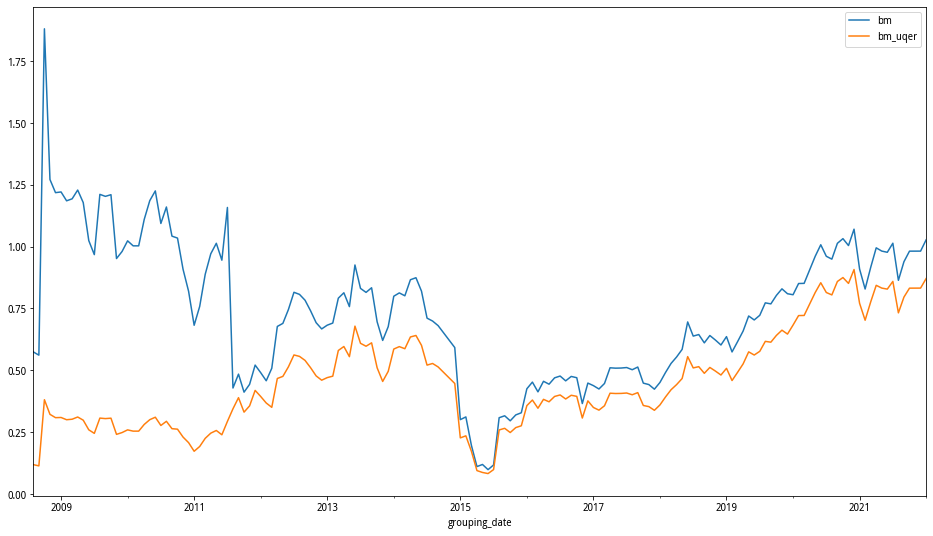

In [161]:
sample_id = np.random.choice(ret_df['secID'].unique(),1)
display(ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']])
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bcdc3e790>,
      dtype=object)

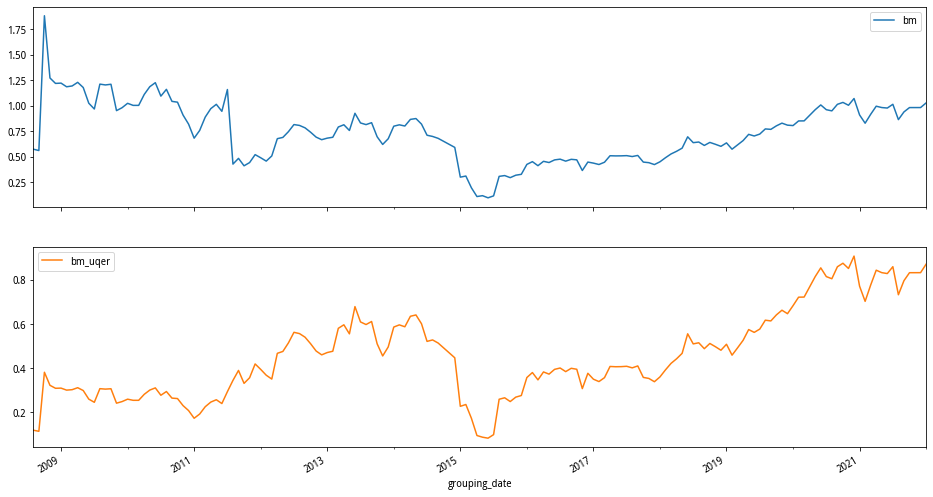

In [162]:
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot(subplots=True)

In [163]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm_uqer'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm_uqer'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm_uqer']) & (ret_df_q['bm_uqer'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm_uqer'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.002606  0.008476  0.009460  0.010043  0.012505  0.012073  0.012316   
t-value  0.358723  1.127717  1.216045  1.355313  1.610175  1.619478  1.619658   

               p8       p9       p10    p10-p1  
mean     0.012382  0.01227  0.011069  0.008462  
t-value  1.650943  1.63834  1.494679  2.125298

# Double Sorting on Size and BM

In [164]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_bm = dict()
keys = ['q_bm_1','q_bm_2']
values = [0.3, 0.7]
q_bm.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['grouping_date'])['size'].quantile(value)

q_bm_df = pd.DataFrame()
for key, value in q_bm.items():
    q_bm_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='grouping_date')
ret_df_q = pd.merge(ret_df_q, q_bm_df, on='grouping_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]

portfolios_bm = dict()
portfolios_bm['bm1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q_bm_1'],
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm2'] = ret_df_q.loc[(ret_df_q['bm'] >= ret_df_q['q_bm_1']) & \
                                           (ret_df_q['bm'] <= ret_df_q['q_bm_2']),
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm3'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q_bm_2'],
                                           ['secID','grouping_date','ret_date','exret','bm']]

portfolios = dict()
for bm_group in portfolios_bm.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{bm_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_bm[bm_group][['secID','ret_date','bm']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有bm和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['bm1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(178,)
(178,)
(178,)
(178,)
(178,)
(178,)


bm1_size1  bm1_size2  bm2_size1  bm2_size2  bm3_size1  bm3_size2
ret_mean   0.009598   0.003481   0.015841   0.005217   0.020767   0.004902
t_values   1.232153   0.493911   2.028635   0.720703   2.441580   0.685649

# Fama MacBeth regression

In [165]:
# ret_df[(ret_df['ret_date'] >= '2008-02') & (ret_df['secID'] == '000001.XSHE')]

In [166]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret100'], X=df_.loc[:,['beta','size','bm']])
    return np.insert(reg.coef_, 0, reg.intercept_)

temp = ret_df.groupby('ret_date').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef','size_coef', 'bm_coef']
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef   bm_coef
ret_mean   9.381665   0.364258  -0.403636  0.035598
t_values   2.460639   0.962976  -2.494257  0.607668

# Fama French 3 factors

Fama-French 3 factors 的构建：

- Market return 就是 CAPM 里面的市场收益率
- 另外还有 SMB，HML，也即 Small-Minus-Big, High-Minus-Low

构建方法：

- mktcap1 也叫做 Small, mktcap2 Big. bm1 Low, bm2 Medium, bm3 High. 
- 因此对应的，我们的
    - bm1_mktcap1: SL
    - bm2_mktcap1: SM
    - bm3_mktcap1: SH
    - bm1_mktcap2: BL
    - bm2_mktcap2: BM
    - bm3_mktcap2: BH
- 在 Fama French (1993) 的构建里，mktcap 是在t年6月形成并保持到t+1年5月不变。bm和我们这里的构建一样，t年6月按照t-1年的BM ratio构建，保持到t+1年5月不变。
- Fama French 计算了这6组资产组合每一年从7月到下一年6月(资产形成期的第二个月的收益率)的 value-weighted excess return。weight 是t年6月的mktcap占所在portfolio 总的 mktcap 的比重。
- SMB: (SL+SM+SH)/3 - (BL+BM+BH)/3。这样构建的意思是把BM的影响平均掉。
- HML: (SH+BH)/2 - (SL+BL)/2

这里我们还是按照mktcap组合的构建日期，不改成和 Fama-French (1993) 原文一样的日期(t年6月)

In [167]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['bm1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"bm1_size1": "SL",
                                    "bm2_size1": "SM",
                                    "bm3_size1": "SH",
                                    "bm1_size2": "BL",
                                    "bm2_size2": "BM",
                                    "bm3_size2": "BH"},
                          inplace=True)

In [168]:
SMB = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 - \
      (portfolios_vwret_df['BL'] + portfolios_vwret_df['BM'] + portfolios_vwret_df['BH']) / 3 

HML = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 - \
      (portfolios_vwret_df['SL'] + portfolios_vwret_df['BL']) / 2 

factors_df = pd.DataFrame(np.vstack([SMB,HML])).T
factors_df.columns = ['SMB','HML']
factors_df.index = SMB.index

In [169]:
factors_df

SMB       HML
ret_date                    
2007-05  -0.031591 -0.021360
2007-06  -0.117856 -0.000611
2007-07   0.071317  0.021021
2007-08  -0.065446  0.030286
2007-09  -0.020948  0.048817
2007-10  -0.110560  0.005402
2007-11   0.113938  0.017011
2007-12   0.065398 -0.022715
2008-01   0.064591 -0.012904
2008-02   0.084902  0.007286
...            ...       ...
2021-05   0.027934 -0.018596
2021-06   0.028139 -0.032799
2021-07   0.043955 -0.032335
2021-08   0.010960  0.052207
2021-09  -0.029921  0.046108
2021-10  -0.014233 -0.053258
2021-11   0.123285 -0.031466
2021-12   0.015507  0.051330
2022-01  -0.003798  0.069385
2022-02   0.023980 -0.009554

[178 rows x 2 columns]

百度百科：中证800指数是由中证指数有限公司编制，其成份股是由中证500和沪深300成份股一起构成，中证800指数综合反映沪深证券市场内大中小市值公司的整体状况。

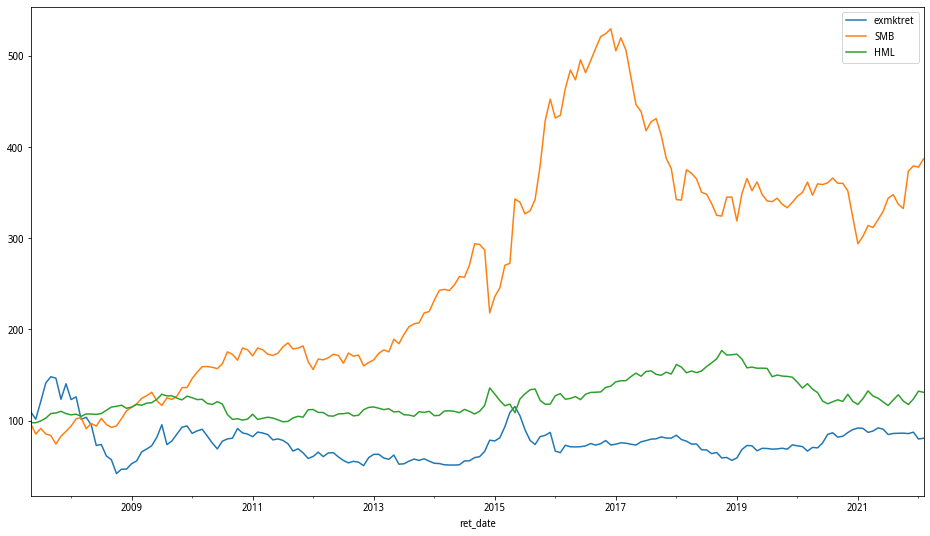

In [170]:
# index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')

index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1

index_df = pd.merge(index_df,rf,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

index_df.drop(['ym','mktret','rf','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)

index_df.dropna(inplace=True)

factors_df = pd.merge(index_df, factors_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

((1 + factors_df).cumprod()*100).plot()

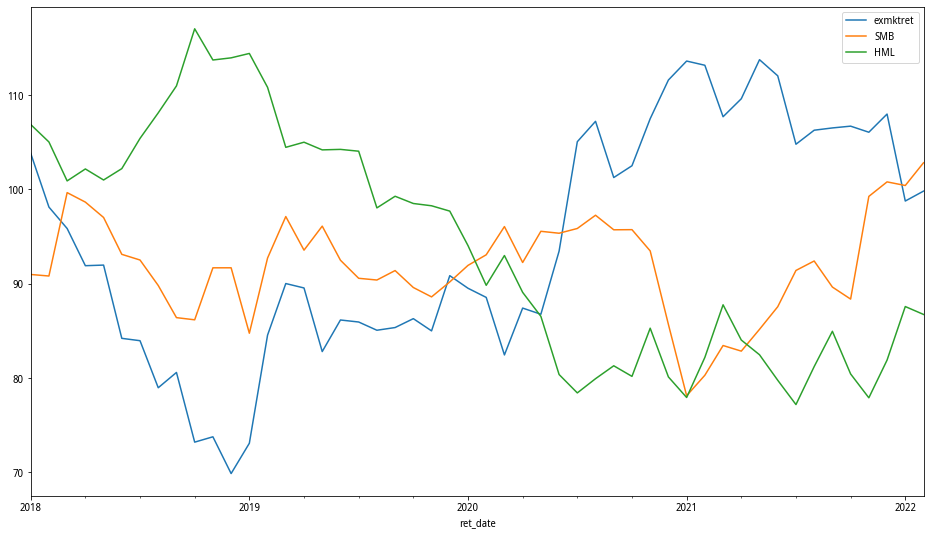

In [175]:
((1 + factors_df.loc['2018':]).cumprod()*100).plot()

In [171]:
factors_df

exmktret       SMB       HML
ret_date                                
2007-05-31  0.098693 -0.031591 -0.021360
2007-06-30 -0.074622 -0.117856 -0.000611
2007-07-31  0.192240  0.071317  0.021021
2007-08-31  0.167193 -0.065446  0.030286
2007-09-30  0.047263 -0.020948  0.048817
2007-10-31 -0.010382 -0.110560  0.005402
2007-11-30 -0.157389  0.113938  0.017011
2007-12-31  0.137366  0.065398 -0.022715
2008-01-31 -0.123254  0.064591 -0.012904
2008-02-29  0.024010  0.084902  0.007286
...              ...       ...       ...
2021-05-31  0.037799  0.027934 -0.018596
2021-06-30 -0.015034  0.028139 -0.032799
2021-07-31 -0.064776  0.043955 -0.032335
2021-08-31  0.014199  0.010960  0.052207
2021-09-30  0.002272 -0.029921  0.046108
2021-10-31  0.001777 -0.014233 -0.053258
2021-11-30 -0.006047  0.123285 -0.031466
2021-12-31  0.018185  0.015507  0.051330
2022-01-31 -0.085436 -0.003798  0.069385
2022-02-28  0.010633  0.023980 -0.009554

[178 rows x 3 columns]

In [172]:
factors_df.to_csv('./data/factors/ff3.csv')

## Long-only factors

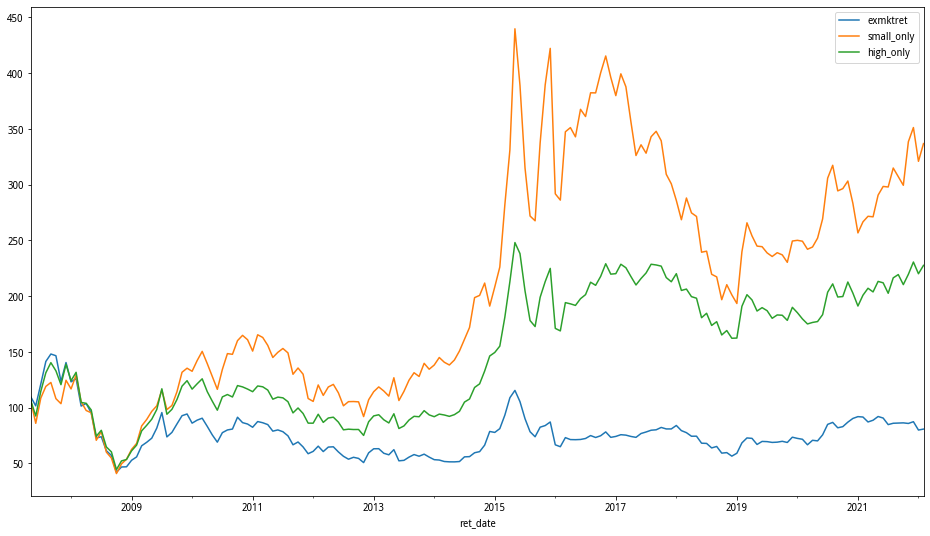

In [173]:
small_only = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 

high_only = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 

factors_long_df = pd.DataFrame(np.vstack([small_only,high_only])).T
factors_long_df.columns = ['small_only','high_only']
factors_long_df.index = small_only.index

factors_long_df = pd.merge(index_df, factors_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

((1 + factors_long_df).cumprod()*100).plot()

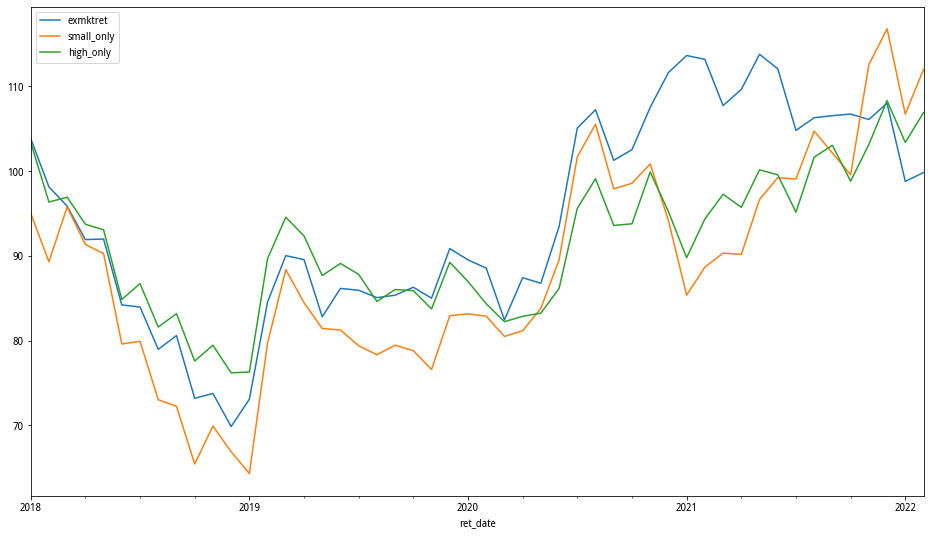

In [174]:
((1 + factors_long_df.loc['2018':]).cumprod()*100).plot()

In [176]:
factors_long_df

exmktret  small_only  high_only
ret_date                                   
2007-05-31  0.098693    0.066489   0.067012
2007-06-30 -0.074622   -0.193444  -0.132361
2007-07-31  0.192240    0.262729   0.238425
2007-08-31  0.167193    0.096661   0.145653
2007-09-30  0.047263    0.029647   0.069091
2007-10-31 -0.010382   -0.118364  -0.052297
2007-11-30 -0.157389   -0.041802  -0.093127
2007-12-31  0.137366    0.202811   0.151152
2008-01-31 -0.123254   -0.062278  -0.105938
2008-02-29  0.024010    0.106350   0.060789
...              ...         ...        ...
2021-05-31  0.037799    0.071772   0.046185
2021-06-30 -0.015034    0.026750  -0.005860
2021-07-31 -0.064776   -0.001619  -0.044277
2021-08-31  0.014199    0.057072   0.068252
2021-09-30  0.002272   -0.024647   0.013658
2021-10-31  0.001777   -0.025143  -0.041059
2021-11-30 -0.006047    0.130358   0.043855
2021-12-31  0.018185    0.037671   0.050223
2022-01-31 -0.085436   -0.086267  -0.045570
2022-02-28  0.010633    0.049548   0.034011

[178 rows x 3 columns]

In [177]:
factors_long_df.to_csv('./data/factors/ff3_long_only.csv')